In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import glob
import yt
from yt.units import kpc
import ytree
from matplotlib.patches import Rectangle
import pandas as pd
import time
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.interpolate import griddata
from scipy import interpolate
CMAP = cm.coolwarm
# import hmf
# from hmf import MassFunction
from scipy import special
import random
from scipy.stats import poisson

### Cosmo Params

In [2]:
OMEGA_B = 0.0486 
OMEGA_M = 0.307
OMEGA_L = 1-OMEGA_M
SIGMA_8 = 0.8159
delta_c = 1.686
h=0.677
rho_crit = 1.5*1e11 #Msol/mpc^3
T_HUBBLE = 4.55e17 #s


K = 1.380649e-16 #ergs/K
SEC_PER_MYR = 3.15576e+13
m_p = 1.6e-27
msol = 2e30
mpc = 3.086e+24
n = rho_crit*msol/mpc**3*OMEGA_B/m_p #cm^-3

In [3]:
# mf = MassFunction.get_all_parameter_defaults(recursive=False)
# print(mf)

In [4]:
# print(mf["z"])

###  Functions for finding dcbh halos

In [5]:

def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z

def r_vir(m_h,z):
    #returns mpc
    h=0.7
    
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1
    delta_c = 18*np.pi*np.pi + 82*d -39*d*d

    return 1e-3*0.784/h* np.float_power(m_h*h/1e8, 1.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * (delta_c/(18*np.pi*np.pi)), -1.0/3) * (10/(1+z))

def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z


def T_vir(m,z):
    h=0.7
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    u=1.22 #for neutral primordial gas
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def T_vir_inverted(T,z):
    h=0.7
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    u=1.22 #for neutral primordial gas
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    m = np.float_power(T/(1.98e4*(u/0.6))/(np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0), 3.0/2.0)*1e8/h
    return m



def U(n_h, temps):  #ergs/cm^3
    #V = 4/3*np.pi*np.power(r,3)
    return 1.5*n_h*K*temps#*V

def calc_k_LW(J_lw):
    return 1.39e-12*J_lw

def calc_n_H(T):
    return 6*np.power(T/1000, 1.5) #cm^-3

def calc_n_e(T):
    return 1.2e-5*np.sqrt(OMEGA_M)/(h*OMEGA_B)*calc_n_H(T)

def calc_k9(T):
    a = np.power(T, 0.928)
    b = np.exp(-T/16200)
    k9 = 1.4e-18*a*b
    return k9

def calc_n_h2(J_lw,T):
    k9 = calc_k9(T)
    n_e = calc_n_e(T)
    n_H = calc_n_H(T)
    k_LW = calc_k_LW(J_lw)
    return min(k9*n_H*n_e/k_LW,1e3)


def dynamical_heating(mass_list,dm_list, dt_list,z_list, temp_list):

    dmdt = dm_list/dt_list
    dedt =  temp_list/mass_list * K/(5.0/3.0-1.0) * dmdt/SEC_PER_MYR
    return dedt



def cooling_rate(T):
    T = T/1000.0
    ortho_para_ratio = 3.0
    total = ortho_para_ratio+1.0
    ortho_fraction = ortho_para_ratio/total
    para_fraction = ortho_para_ratio/total

    a_list1_ortho = np.array([-24.330855, 4.4404496, -4.0460989, -1.1390725, 9.8094223, 8.6273872, 0.0, 0.0] )
    a_list2_ortho = np.array([-24.329086, 4.6105087, -3.950535, 12.363818, -32.403165, 48.853562, -38.542008, 12.06677])
    a_list1_para = np.array([-24.216387, 3.323748, -11.642384, -35.553366, -35.105689, -10.922078, 0.0, 0.0] )
    a_list2_para = np.array([-24.216387, 4.2046488, -1.3155285, -1.6552763, 4.1780102, -0.56949697, -3.3824407, 1.0904027])

    cooling_rates = []
    for t in T:
        if(t<1000.0): cooling_rates.append(ortho_fraction*power_series(a_list1_ortho, t)+ para_fraction*power_series(a_list1_para, t))
        else: cooling_rates.append(ortho_fraction*power_series(a_list2_ortho, t)+ para_fraction*power_series(a_list2_para, t))
    return cooling_rates


def cooling_LTE(temps, n_h):
    T = temps/1.0e3
    a = 9.5e-22*np.power(T, 3.76)/(1+0.12*np.power(T, 2.1))*np.exp(-2.197e-3/np.power(T,3))
    b = 3e-24*np.exp(-0.51/T) + 6.7e-19*np.exp(-5.86/T)
    c = 1.6e-18*np.exp(-11.7/T)
    return (a+b+c)/n_h


def cooling_GP(T):
    T=np.log10(T)
    return np.power(10,-103.0 + 97.59*T -48.05*T**2 + 10.80*T**3-0.9032*T**4)

def power_series(constants, x):
    x = np.log10(x)
    return np.power(10,np.sum(constants*np.power(x,np.arange(0,len(constants), 1))))



def total_cooling_rate(temps, n_h):
    a = cooling_LTE(temps, n_h)
    b = cooling_GP(temps)
    return a/(1+a/b)


def atomic_cooling_halos(temps):
    no_index = np.where(temps < 1e4)
    arr = np.full(len(temps), True)
    arr[no_index] = False
    return arr

def calc_t_cool(mass, dm,dt,zs, temps, j_lw):
    n_h = calc_n_H(temps)
    n_h2 = calc_n_h2(j_lw, temps)

    u = U(n_h, temps)
    c = total_cooling_rate(temps,n_h)*n_h*n_h2
    h = dynamical_heating(mass, dm, dt,zs, temps)*n_h
    ch = c-h

    ch[np.where(ch==0)] = 1e-50
    t_cool = u/(ch)
    t_cool = np.array(t_cool)
    t_cool[np.where(np.isnan(t_cool) == True)] = 1e20
    t_cool[np.where(np.isinf(t_cool) == True)] = 1e20
    injection = np.where(t_cool <= 0)
    t_cool[injection] = 1e20
    return t_cool

def cooling_condition(t_cool,prog_counts, times):
    myr_to_sec = 3.15576e+13
    no_index = np.where(t_cool < times*myr_to_sec/np.sqrt(200))
    arr = np.full(len(t_cool), True)
    arr[no_index] = False
    yes_index = np.where(prog_counts == 0)
    arr[yes_index] = True
    return arr

def z_to_time(z):
    a=2./(3.*np.sqrt(OMEGA_L))
    b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
    c = 71*1e5*3.154e+7/3.086e18
    return a/c*np.log(b+np.sqrt(1+b*b))
    

# Functions for evaluating mass ratio in dcbh halos

In [6]:
#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10
#1/30/2022, updating the values for the row: TRUE, SF, ALL, EXCL

E0 = -1.494
Ea = 1.569
Elna = 1.293
Ez = -0.215
M0 = 12.059
Ma = 4.645
Mlna = 4.544
Mz = -0.757
A0 = 1.905
Aa = -2.555
Alna = -1.875
Az = 0.197
B0 = 0.509
Ba = -0.889
Bz = -0.538
D0 = 0.460
Y0 = -0.807
Ya = -1.859
Yz = -0.637
Msol = 1.989e30

def a(z0):
    return 1/(1+z0)

def log10_m_2(z0):
    return M0 + Ma*(a(z0)-1) - Mlna*np.log(a(z0)) + Mz*z0 #+math.log10(Msol)

def epsilon2(z0):
    return E0 + Ea*(a(z0)-1) - Elna*np.log(a(z0)) + Ez*z0

def alpha2(z0):
    return A0 + Aa*(a(z0)-1) - Alna*np.log(a(z0)) + Az*z0

def beta2(z0):
    return B0 + Ba*(a(z0)-1) + Bz*z0

def delta2(z0):
    return D0

def gamma2(z0):
    return 10**(Y0 + Ya*(a(z0)-1) + Yz*z0) 


def get_peak(mass):
    peak = 0
    for x in range(len(mass)):
        if(mass[x] < peak): mass[x] = peak
        else: peak = mass[x]
    return mass


#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.float_power(10, -alpha2(z)*x) + np.float_power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.float_power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    sm = np.float_power(10, log10_m_s)
    min_mass = 100
    sm[np.where(sm < min_mass)]= min_mass
    return sm

def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed):  
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)

    if(seed == -1): bh_mass = [cap[0]]
    else: bh_mass = [seed]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass

def evolve_BH_super(halo_mass, time, folding_time, fraction_cap, seed):    
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    dm = (np.array(halo_mass[1:len(halo_mass)])-np.array(halo_mass[0:len(halo_mass)-1])) 
    
    p,F=0.6,0.1
    reset_power = True
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)
    t_super = 0
    
    
#     if(seed <= cap[0]): bh_mass = [seed]
#     else:
    bh_mass = [cap[0]]
    
    for i in range(len(dt)):
        
        old_mass = bh_mass[i]
        c = cap[i+1]

        
        m_edd = (1/folding_time)*bh_mass[i]
        m_dot = F*(OMEGA_B/OMEGA_M)*(dm[i]/dt[i])
        if(m_dot < 0): m_dot = 0
        

        if(5*m_dot > 3*m_edd): 
            if(reset_power): i_start = i
               
            t_super  =time[i+1]-time[i_start]
            m_dot_av = F*(OMEGA_B/OMEGA_M)*(halo_mass[i+1]-halo_mass[i_start])/(t_super)
            new_mass = m_dot_av*np.float_power( np.float_power(3/(5*folding_time), p) * t_super*(1-p),1/(1-p)) + bh_mass[i_start]
            reset_power = False
        else: 
            new_mass = m_dot*dt[i] + old_mass
            reset_power = True

            
            
        if(new_mass <= c): 
            bh_mass.append(new_mass)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass


def find_ratio_lifetime_merged(all_trees_raw,tau_fold,f_cap, ratio_min = 1e-1, total_time = False,edd_growth=True, optimistic=True):
    dt_arr = []
    taus = []
    
    merged_trees = evolve_BH_with_mergers(all_trees_raw, tau=tau_fold, cap=f_cap, optimistic=optimistic)
    for t in merged_trees:
        redshift, time,halo_mass = t[0],t[1],t[2]
        stellar_mass = t[3]
        tau = time[-1]-time[0]
        taus.append(tau)
        bh_mass = t[4]
        
        t0 = time[0]
        if(not total_time):
            dt = time[-1] - t0 
            for x in range(len(time)):
                if(bh_mass[x]/stellar_mass[x] < ratio_min): 
                    dt = time[x]-t0
                    break
        if(total_time):
            dt =0
            for x in range(1,len(time)):
                if(bh_mass[x-1]/stellar_mass[x-1] > ratio_min): dt += time[x]-time[x-1]

        dt_arr.append(dt)
    dt_arr = np.array(dt_arr)
    return dt_arr, taus

def find_ratio_lifetime(trees,tau_fold,f_cap,seed_mass, ratio_min = 1e-1, total_time = False,edd_growth=True):
    dt_arr = []
    taus = []
    
    for t in trees:
        redshift, time,halo_mass = t[0],t[1],t[2]
        stellar_mass = calc_mass(halo_mass, redshift,time)
        tau = time[-1]-time[0]
        taus.append(tau)
        if(edd_growth): bh_mass = evolve_BH(halo_mass,time,tau_fold,f_cap,seed_mass)
        else: bh_mass = evolve_BH_super(halo_mass,time,tau_fold,f_cap,seed_mass)
        
        t0 = time[0]
        if(not total_time):
            dt = time[-1] - t0 
            for x in range(len(time)):
                if(bh_mass[x]/stellar_mass[x] < ratio_min): 
                    dt = time[x]-t0
                    break
        if(total_time):
            dt =0
            for x in range(1,len(time)):
                if(bh_mass[x-1]/stellar_mass[x-1] > ratio_min): dt += time[x]-time[x-1]

        dt_arr.append(dt)
    dt_arr = np.array(dt_arr)
    return dt_arr, taus


def find_min_max_bh(all_trees, SUPER=False):
    index = 4
    final_bh_mass = np.array([t[4][-1] for t in all_trees])
    smallest_arg, largest_arg = np.argmin(final_bh_mass), np.argmax(final_bh_mass)

    least_massive_sm = all_trees[smallest_arg][3]
    least_massive_bh = all_trees[smallest_arg][index]
    most_massive_sm  = all_trees[largest_arg][3]
    most_massive_bh  = all_trees[largest_arg][index]
    return least_massive_sm, least_massive_bh, most_massive_sm, most_massive_bh


def calc_mass_wise(z,m_h):
    
    
    m_h = np.log10(m_h)
    mh_filter = np.where((6<m_h) &(m_h<9))
    m_h = m_h[mh_filter]

    m_vir_power = np.arange(6.5,8.6, 0.5)
    m_star_power = [3.41, 3.59,3.88,4.60,5.74]
    f =interpolate.interp1d(m_vir_power, m_star_power, bounds_error=False, kind='cubic' )
    m_star = f(m_h)
    return z[mh_filter], np.power(10, m_h), np.power(10, m_star)

def calc_mass(m_h,z,time):
    fraction =0.005
    behroozi_mass_index_first = np.where((m_h > 1e8) &(z<12))[0][0]
    fractional_mass = fraction*OMEGA_B/OMEGA_M*m_h
    end=behroozi_mass_index_first
    stellar_mass = np.zeros(len(m_h))
    beh_mass = calc_mass_beh_2019(m_h[end:],z[end:])

    
    m0 = fractional_mass[0]
    mf = beh_mass[0]
    slope = (mf-m0)/(m_h[end] - m_h[0])
    for x in range(end):
        stellar_mass[x] = (m_h[x]-m_h[0])*slope + m0
    for x in range(end,len(m_h)):
        stellar_mass[x] = beh_mass[x-end]
    

    return stellar_mass



def append_data_to_tree(tree):
    new_tree = []
    for branch in tree:
        z,m = branch[0], branch[1]
        time = z_to_time(z)
        sm = calc_mass(m,z,time)    
#         sm = sm1#np.maximum(sm1,sm2)
        bhm = evolve_BH(m, time, 40, 0.05,1e5)
        new_tree.append(np.array([z,time,m,sm,bhm]))
    return np.array(new_tree)

### MM and LW Data

In [7]:
mm_mass = [541340.0, 861230.0, 1230300.0, 1722500.0, 2780500.0, 3863200.0, 4945900.0, 5930200.0, 6766800.0, 7628000.0, 8636900.0, 9645800.0, 11221000.0, 13115000.0, 15871000.0, 20350000.0, 64814000.0, 76280000.0, 86935000.0, 91979000.0, 99287000.0, 104630000.0, 110340000.0, 117500000.0, 123840000.0, 127900000.0, 135780000.0, 144150000.0, 149210000.0, 155050000.0, 157730000.0, 165530000.0, 180100000.0, 188410000.0, 200100000.0, 204190000.0, 209480000.0, 203320000.0, 207190000.0, 213760000.0, 220500000.0, 241090000.0, 256550000.0, 266390000.0, 268240000.0, 267990000.0, 214000000.0, 249190000.0, 235160000.0, 193785000.0, 152410000.0, 174383300.0, 196356700.0, 218330000.0, 112430000.0, 105220000.0, 85803000.0, 49976000.0, 95695000.0, 48376000.0, 37254000.0, 36516000.0, 37673000.0, 34203000.0, 29060000.0, 25000000.0, 32013000.0, 25172000.0, 26280000.0, 25222000.0, 24090000.0, 23893000.0, 22638000.0, 22687000.0, 22761000.0, 23499000.0, 24434000.0, 75017000000.0, 78981000000.0, 82722000000.0, 86786000000.0, 91149000000.0, 94826000000.0, 95746000000.0, 98578000000.0, 101790000000.0, 104830000000.0, 107940000000.0, 111260000000.0, 115500000000.0, 119740000000.0, 124860000000.0, 130700000000.0, 136770000000.0, 142220000000.0, 146830000000.0, 150580000000.0, 154870000000.0, 158590000000.0, 158850000000.0, 159660000000.0, 162670000000.0, 166150000000.0, 169670000000.0, 173770000000.0, 177870000000.0, 181760000000.0, 185090000000.0, 187990000000.0, 190840000000.0, 194270000000.0, 198680000000.0, 202340000000.0, 205390000000.0, 210680000000.0, 214630000000.0, 218230000000.0, 221750000000.0, 225400000000.0, 229160000000.0, 233470000000.0, 238100000000.0, 242730000000.0, 247050000000.0, 251060000000.0, 255260000000.0, 259650000000.0, 263360000000.0, 266940000000.0, 270080000000.0, 273260000000.0, 276010000000.0, 278710000000.0, 281150000000.0, 281300000000.0]
mm_time = [148.80977113935595, 154.7551727054681, 160.72201956215898, 166.65109675362595, 172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_pos = [[13623.54, 13553.191, 12954.65], [13629.83, 13551.641, 12967.99], [13636.011, 13549.74, 12981.77], [13642.01, 13547.761, 12995.5], [13648.311, 13545.971, 13009.44], [13654.51, 13543.931, 13023.361], [13660.93, 13541.801, 13037.33], [13667.0, 13539.61, 13050.42], [13673.15, 13537.61, 13063.84], [13678.841, 13535.691, 13076.75], [13684.681, 13533.721, 13089.771], [13690.621, 13531.531, 13102.711], [13696.391, 13529.24, 13115.181], [13701.841, 13526.931, 13127.73], [13707.49, 13524.71, 13140.13], [13713.36, 13522.421, 13152.55], [13755.319, 13509.17, 13236.05], [13761.08, 13506.501, 13247.74], [13766.971, 13502.78, 13257.761], [13772.471, 13500.331, 13269.911], [13780.2295, 13498.311, 13280.421], [13784.54, 13494.991, 13290.511], [13790.74, 13493.07, 13300.541], [13796.051, 13491.951, 13310.32], [13801.091, 13489.75, 13320.221], [13806.95, 13487.26, 13330.19], [13814.241, 13485.989, 13341.35], [13823.82, 13485.211, 13351.961], [13826.5205, 13483.1, 13361.91], [13832.671, 13481.23, 13372.171], [13838.931, 13478.541, 13382.631], [13846.051, 13475.251, 13392.411], [13852.98, 13474.09, 13402.551], [13858.491, 13470.9795, 13412.28], [13865.7, 13469.341, 13422.011], [13872.461, 13466.791, 13431.561], [13879.49, 13464.521, 13440.9], [13885.67, 13460.931, 13450.32], [13892.19, 13458.48, 13459.66], [13900.111, 13455.61, 13469.25], [13906.82, 13452.51, 13478.66], [13913.761, 13449.661, 13488.101], [13920.931, 13446.34, 13497.812], [13928.561, 13442.951, 13507.24], [13936.41, 13439.4795, 13516.511], [13945.15, 13435.641, 13526.001], [13954.681, 13431.301, 13535.661], [13965.61, 13425.561, 13545.21], [13976.58, 13420.11, 13554.31], [13987.461, 13413.63, 13559.34], [13989.951, 13412.341, 13569.641], [14010.7705, 13399.971, 13575.631], [14017.951, 13395.591, 13581.94], [14024.551, 13391.791, 13588.26], [14030.49, 13388.251, 13594.931], [14035.04, 13386.091, 13601.961], [14039.61, 13383.891, 13609.041], [14043.721, 13382.301, 13615.891], [14047.261, 13381.11, 13622.63], [14050.471, 13380.32, 13629.811], [14053.251, 13379.811, 13636.72], [14055.61, 13379.69, 13643.851], [14057.58, 13380.09, 13650.57], [14059.201, 13380.391, 13657.481], [14060.551, 13381.67, 13664.5205], [14061.851, 13383.24, 13671.37], [14062.69, 13385.311, 13678.03], [14063.091, 13388.02, 13684.891], [14063.48, 13390.971, 13691.75], [14063.51, 13394.431, 13698.54], [14063.341, 13398.57, 13705.301], [14062.801, 13403.091, 13711.931], [14062.15, 13408.52, 13718.95], [14060.71, 13414.791, 13725.501], [14059.141, 13422.069, 13732.181], [14056.74, 13430.79, 13738.561], [14054.401, 13440.61, 13745.941], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]
mm_rad = [2.144, 2.503, 2.819, 3.153, 3.699, 4.127, 4.482, 4.761, 4.975, 5.178, 5.397, 5.599, 5.889, 6.203, 6.61, 7.181, 10.502, 10.89, 11.65, 11.847, 12.179, 12.394, 12.615, 12.882, 13.11, 13.25, 13.518, 13.787, 13.84, 14.065, 14.119, 14.429, 14.831, 14.867, 15.156, 15.271, 15.416, 15.239, 15.26, 15.09, 15.133, 15.755, 15.747, 15.782, 15.365, 15.185, 14.208, 14.417, 13.588, 13.218, 12.826, 12.762, 12.697, 12.631, 10.983, 10.736, 9.918, 8.953, 9.865, 8.872, 8.5, 8.306, 8.364, 8.236, 7.937, 7.578, 7.954, 7.575, 7.652, 7.536, 7.275, 7.275, 7.105, 7.057, 6.857, 6.704, 6.121, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]
mm_tforce = [0.05651, 0.06533, 0.06987, 0.11627, 0.1239, 0.11384, 0.13591, 0.14901, 0.15361, 0.16428, 0.17434, 0.18775, 0.19413, 0.21015, 0.22637, 0.2535, 0.23572, 0.25516, 0.25351, 0.28555, 0.32018, 0.32184, 0.28095, 0.29294, 0.30664, 0.33046, 0.33252, 0.35734, 0.37146, 0.40654, 0.46308, 0.49332, 0.47857, 0.5659, 0.50524, 0.5936, 0.67406, 0.81269, 0.72398, 0.80167, 0.8169, 1.07786, 1.32233, 1.59768, 1.77301, 2.0298, 2.35823, 3.27054, 4.86138, 5.68795, 4.93198, 2.73607, 2.21637, 2.31732, 2.07117, 1.96389, 1.88409, 1.78291, 1.76178, 1.7404, 1.72068, 1.71519, 1.70252, 1.70123, 1.72108, 1.76792, 1.84077, 1.87632, 1.95924, 2.05447, 2.18583, 2.35829, 2.5975, 3.03877, 3.57521, 4.58045, 6.37613, 0.11763, 0.11821, 0.11889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17544, 0.17859, 0.18196, 0.18624, 0.18888, 0.18969, 0.18906, 0.18847, 0.18652, 0.18438, 0.18474, 0.18543, 0.18815, 0.19005, 0.19742, 0.19421, 0.19554, 0.20027, 0.1979, 0.1991, 0.19989, 0.19796, 0.20195, 0.20285, 0.20405, 0.20592, 0.2069, 0.20621]
mm_pos_cm = [[5.9208242e+25, 5.89025e+25, 5.630123e+25], [5.923558e+25, 5.8895764e+25, 5.6359207e+25], [5.926244e+25, 5.8887504e+25, 5.641909e+25], [5.9288513e+25, 5.8878903e+25, 5.647876e+25], [5.9315893e+25, 5.8871124e+25, 5.653935e+25], [5.934284e+25, 5.8862255e+25, 5.659985e+25], [5.937074e+25, 5.8853e+25, 5.666056e+25], [5.939712e+25, 5.884348e+25, 5.6717448e+25], [5.942385e+25, 5.883479e+25, 5.677577e+25], [5.9448576e+25, 5.8826445e+25, 5.6831877e+25], [5.947396e+25, 5.8817886e+25, 5.6888467e+25], [5.949978e+25, 5.8808368e+25, 5.6944702e+25], [5.952485e+25, 5.879841e+25, 5.69989e+25], [5.954854e+25, 5.878837e+25, 5.705344e+25], [5.957309e+25, 5.8778724e+25, 5.710733e+25], [5.9598603e+25, 5.876877e+25, 5.716131e+25], [5.978096e+25, 5.8711186e+25, 5.75242e+25], [5.9805995e+25, 5.8699587e+25, 5.7575005e+25], [5.983159e+25, 5.8683414e+25, 5.7618557e+25], [5.9855497e+25, 5.867277e+25, 5.767136e+25], [5.988922e+25, 5.866399e+25, 5.771704e+25], [5.990795e+25, 5.8649564e+25, 5.776089e+25], [5.9934897e+25, 5.8641217e+25, 5.7804477e+25], [5.9957973e+25, 5.863635e+25, 5.7846983e+25], [5.997988e+25, 5.8626787e+25, 5.7890006e+25], [6.0005345e+25, 5.8615964e+25, 5.7933337e+25], [6.003703e+25, 5.8610443e+25, 5.7981834e+25], [6.0078666e+25, 5.860706e+25, 5.802795e+25], [6.00904e+25, 5.8597886e+25, 5.807119e+25], [6.0117127e+25, 5.858976e+25, 5.8115785e+25], [6.0144336e+25, 5.857807e+25, 5.816124e+25], [6.0175276e+25, 5.8563773e+25, 5.820375e+25], [6.0205395e+25, 5.855873e+25, 5.8247813e+25], [6.0229343e+25, 5.854521e+25, 5.82901e+25], [6.0260675e+25, 5.8538086e+25, 5.8332386e+25], [6.0290056e+25, 5.8527004e+25, 5.837389e+25], [6.032061e+25, 5.851714e+25, 5.8414484e+25], [6.0347463e+25, 5.850154e+25, 5.8455426e+25], [6.03758e+25, 5.8490885e+25, 5.8496014e+25], [6.0410228e+25, 5.8478415e+25, 5.8537694e+25], [6.0439383e+25, 5.846494e+25, 5.857859e+25], [6.046955e+25, 5.8452558e+25, 5.8619616e+25], [6.050071e+25, 5.8438123e+25, 5.866182e+25], [6.0533867e+25, 5.84234e+25, 5.87028e+25], [6.056798e+25, 5.8408313e+25, 5.874309e+25], [6.060597e+25, 5.8391623e+25, 5.878433e+25], [6.064739e+25, 5.837276e+25, 5.8826316e+25], [6.069489e+25, 5.8347817e+25, 5.8867817e+25], [6.0742564e+25, 5.832413e+25, 5.8907367e+25], [6.078985e+25, 5.8295963e+25, 5.8929226e+25], [6.080067e+25, 5.8290365e+25, 5.897399e+25], [6.0891153e+25, 5.82366e+25, 5.9000025e+25], [6.092236e+25, 5.8217565e+25, 5.9027446e+25], [6.0951045e+25, 5.8201055e+25, 5.9054913e+25], [6.0976856e+25, 5.8185666e+25, 5.90839e+25], [6.099663e+25, 5.817628e+25, 5.9114455e+25], [6.1016494e+25, 5.816672e+25, 5.914523e+25], [6.1034355e+25, 5.815981e+25, 5.9174997e+25], [6.104974e+25, 5.815464e+25, 5.9204286e+25], [6.106369e+25, 5.8151202e+25, 5.9235493e+25], [6.1075777e+25, 5.8148984e+25, 5.926552e+25], [6.108603e+25, 5.8148463e+25, 5.929651e+25], [6.1094593e+25, 5.81502e+25, 5.9325716e+25], [6.1101635e+25, 5.8151507e+25, 5.9355747e+25], [6.1107496e+25, 5.815707e+25, 5.938634e+25], [6.111315e+25, 5.816389e+25, 5.9416114e+25], [6.11168e+25, 5.8172887e+25, 5.9445057e+25], [6.111854e+25, 5.8184665e+25, 5.947487e+25], [6.1120234e+25, 5.819749e+25, 5.9504686e+25], [6.1120363e+25, 5.821253e+25, 5.953419e+25], [6.1119625e+25, 5.823052e+25, 5.9563577e+25], [6.1117277e+25, 5.825016e+25, 5.9592387e+25], [6.1114455e+25, 5.827376e+25, 5.9622898e+25], [6.1108192e+25, 5.8301013e+25, 5.9651365e+25], [6.110137e+25, 5.8332645e+25, 5.9680396e+25], [6.109094e+25, 5.8370543e+25, 5.970812e+25], [6.1080776e+25, 5.8413225e+25, 5.97402e+25], [6.1107196e+25, 5.847372e+25, 5.978001e+25], [6.1127054e+25, 5.848828e+25, 5.9810865e+25], [6.1140396e+25, 5.849597e+25, 5.983985e+25], [6.115452e+25, 5.8502322e+25, 5.987418e+25], [6.1165995e+25, 5.850901e+25, 5.9908605e+25], [6.116869e+25, 5.8507663e+25, 5.994837e+25], [6.1176777e+25, 5.8511357e+25, 5.994885e+25], [6.1178036e+25, 5.8512745e+25, 5.9981664e+25], [6.1187204e+25, 5.851453e+25, 6.001847e+25], [6.119229e+25, 5.8519224e+25, 6.0057065e+25], [6.11992e+25, 5.852005e+25, 6.0094004e+25], [6.1197724e+25, 5.851931e+25, 6.013986e+25], [6.120867e+25, 5.8520183e+25, 6.016893e+25], [6.1208414e+25, 5.852222e+25, 6.021287e+25], [6.120837e+25, 5.8523527e+25, 6.025394e+25], [6.1206195e+25, 5.852444e+25, 6.029749e+25], [6.121089e+25, 5.852196e+25, 6.0336865e+25], [6.1211586e+25, 5.851879e+25, 6.037602e+25], [6.125952e+25, 5.8546604e+25, 6.0382235e+25], [6.1220367e+25, 5.8507183e+25, 6.0451857e+25], [6.1227797e+25, 5.8503143e+25, 6.048832e+25], [6.123562e+25, 5.8501276e+25, 6.051931e+25], [6.123384e+25, 5.8497927e+25, 6.05273e+25], [6.123666e+25, 5.8499103e+25, 6.0529085e+25], [6.1240354e+25, 5.8494017e+25, 6.055712e+25], [6.1247613e+25, 5.849432e+25, 6.059067e+25], [6.126513e+25, 5.8538344e+25, 6.063183e+25], [6.1261826e+25, 5.850041e+25, 6.0651036e+25], [6.127017e+25, 5.850162e+25, 6.068159e+25], [6.127708e+25, 5.8509922e+25, 6.0710356e+25], [6.1281993e+25, 5.8520525e+25, 6.0744824e+25], [6.128317e+25, 5.8529476e+25, 6.07865e+25], [6.130746e+25, 5.8543472e+25, 6.08028e+25], [6.128247e+25, 5.8554513e+25, 6.0863644e+25], [6.1286596e+25, 5.857112e+25, 6.0902285e+25], [6.127765e+25, 5.856625e+25, 6.0942347e+25], [6.1249006e+25, 5.852526e+25, 6.0981463e+25], [6.127165e+25, 5.856651e+25, 6.1020234e+25], [6.1268342e+25, 5.8560337e+25, 6.1060037e+25], [6.126709e+25, 5.8554296e+25, 6.1098895e+25], [6.12673e+25, 5.855486e+25, 6.1139962e+25], [6.1272387e+25, 5.8556994e+25, 6.1177252e+25], [6.1278774e+25, 5.855634e+25, 6.1214063e+25], [6.128443e+25, 5.856086e+25, 6.1254134e+25], [6.129221e+25, 5.856612e+25, 6.1290552e+25], [6.1299637e+25, 5.8573333e+25, 6.132936e+25], [6.1306633e+25, 5.8579504e+25, 6.136839e+25], [6.1314455e+25, 5.8587805e+25, 6.14075e+25], [6.1320367e+25, 5.859428e+25, 6.144545e+25], [6.132606e+25, 5.859902e+25, 6.1484603e+25], [6.133301e+25, 5.8608534e+25, 6.1523286e+25], [6.1338966e+25, 5.8614967e+25, 6.15634e+25], [6.1346317e+25, 5.8619833e+25, 6.160069e+25], [6.134975e+25, 5.863565e+25, 6.1641363e+25], [6.136074e+25, 5.8644865e+25, 6.1677477e+25], [6.137087e+25, 5.8656643e+25, 6.1719375e+25], [6.137895e+25, 5.8665945e+25, 6.175845e+25], [6.13793e+25, 5.866677e+25, 6.176101e+25]]
mm_oids = [16320, 9132, 8391, 29644, 25872, 23374, 20473, 4240, 3650, 12300, 10584, 8542, 7275, 991, 677, 692, 484, 17664, 18771, 20018, 21101, 22002, 23168, 24365, 25147, 26482, 27433, 28581, 29537, 29834, 30849, 31670, 31926, 33119, 33886, 95435, 103072, 36812, 103016, 37685, 38316, 112512, 39757, 117540, 40994, 41669, 41922, 43204, 43647, 155133, 44961, 157325, 157845, 45811, 46187, 47518, 46868, 47207, 40362, 40633, 41165, 41362, 41606, 41710, 41715, 42113, 42058, 42541, 42551, 42655, 42906, 42852, 43222, 43371, 43422, 43561, 51190, 127709, 132236, 129983, 144965, 163496, 109009, 125490, 119600, 116652, 131983, 165648, 165826, 130082, 162710, 162968, 159966, 51316, 57954, 60498, 44047, 43669, 59183, 46113, 54598, 62546, 66413, 60424, 73997, 51759, 160537, 159916, 55718, 151243, 43078, 43027, 43319, 157556, 159993, 159474, 159304, 158902, 158107, 156935, 157795, 155677, 157677, 156657, 155041, 155838, 155886, 155494, 155293, 154588, 153914, 153530, 153060, 152755, 153149]
mm_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4336676, 4514815, 4694792, 4876290, 5059504, 5244051, 5430112, 5617360, 5805997, 5995970, 6187016, 6379160, 6572876, 6767498, 6962856, 7159260, 7356174, 7554011, 7752943, 7952437, 8152256, 8352620, 8553283, 8754305, 8955699, 9157673, 9362498, 9565975, 9769559, 9973857, 10177465, 10380179, 10584396, 10788526, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
mm_mvir = [63660000.0, 20350000.0, 15870000.0, 13120000.0, 11220000.0, 9646000.0, 8637000.0, 7628000.0, 6767000.0, 5930000.0, 4946000.0, 3863000.0, 2780000.0, 1722000.0, 1230000.0, 861200.0, 541300.0, 70960000.0, 86890000.0, 91390000.0, 99290000.0, 104600000.0, 110300000.0, 117500000.0, 123800000.0, 127900000.0, 135800000.0, 144000000.0, 145700000.0, 152900000.0, 154700000.0, 165100000.0, 179300000.0, 180600000.0, 191400000.0, 195800000.0, 201400000.0, 194500000.0, 195400000.0, 188900000.0, 190600000.0, 215000000.0, 214700000.0, 216100000.0, 199500000.0, 192500000.0, 157700000.0, 164800000.0, 138000000.0, 127000000.0, 116000000.0, 114300000.0, 112500000.0, 110800000.0, 72860000.0, 68060000.0, 53670000.0, 39470000.0, 52810000.0, 38410000.0, 33780000.0, 31520000.0, 32180000.0, 30730000.0, 27510000.0, 23940000.0, 27680000.0, 23920000.0, 24660000.0, 23550000.0, 21190000.0, 21190000.0, 19730000.0, 19340000.0, 17740000.0, 16580000.0, 12620000.0, 75020000000.0, 78980000000.0, 82720000000.0, 86790000000.0, 91150000000.0, 94830000000.0, 95750000000.0, 98580000000.0, 101800000000.0, 104800000000.0, 107900000000.0, 111300000000.0, 115500000000.0, 119700000000.0, 124900000000.0, 130700000000.0, 136800000000.0, 142200000000.0, 146800000000.0, 150600000000.0, 154900000000.0, 158600000000.0, 158900000000.0, 159700000000.0, 162700000000.0, 166100000000.0, 169700000000.0, 173800000000.0, 177900000000.0, 181800000000.0, 185100000000.0, 188000000000.0, 190800000000.0, 194300000000.0, 198700000000.0, 202300000000.0, 205400000000.0, 210700000000.0, 214600000000.0, 218200000000.0, 221800000000.0, 225400000000.0, 229200000000.0, 233500000000.0, 238100000000.0, 242700000000.0, 247000000000.0, 251100000000.0, 255300000000.0, 259600000000.0, 263400000000.0, 266900000000.0, 270100000000.0, 273300000000.0, 276000000000.0, 278700000000.0, 281100000000.0, 281300000000.0]
mm_pos_cl =[[0.47970212, 0.47722504, 0.45614967], [0.4799236, 0.47717044, 0.45661938], [0.48014122, 0.47710353, 0.45710456], [0.48035246, 0.47703382, 0.45758802], [0.4805743, 0.4769708, 0.4580789], [0.4807926, 0.47689897, 0.45856905], [0.48101866, 0.47682396, 0.4590609], [0.4812324, 0.47674686, 0.45952183], [0.48144895, 0.47667643, 0.45999438], [0.4816493, 0.47660884, 0.46044895], [0.48185495, 0.47653946, 0.46090743], [0.48206413, 0.47646236, 0.46136305], [0.48226726, 0.4763817, 0.46180212], [0.4824592, 0.47630036, 0.46224403], [0.48265812, 0.4762222, 0.46268064], [0.4828648, 0.47614157, 0.46311796], [0.48434225, 0.475675, 0.4660581], [0.48454508, 0.47558102, 0.46646973], [0.48475248, 0.47545, 0.46682256], [0.48494616, 0.47536376, 0.46725038], [0.48521936, 0.47529262, 0.46762046], [0.48537114, 0.47517574, 0.46797574], [0.48558944, 0.47510812, 0.4683289], [0.48577642, 0.4750687, 0.46867326], [0.4859539, 0.4749912, 0.46902186], [0.48616022, 0.47490352, 0.4693729], [0.48641694, 0.4748588, 0.46976584], [0.48675424, 0.47483137, 0.47013947], [0.4868493, 0.47475705, 0.4704898], [0.48706588, 0.4746912, 0.4708511], [0.4872863, 0.4745965, 0.4712194], [0.487537, 0.47448066, 0.47156376], [0.487781, 0.4744398, 0.4719208], [0.48797503, 0.47433028, 0.4722634], [0.4882289, 0.47427255, 0.472606], [0.48846692, 0.47418278, 0.47294226], [0.48871446, 0.47410285, 0.47327113], [0.48893204, 0.47397643, 0.47360283], [0.48916164, 0.47389016, 0.4739317], [0.48944053, 0.4737891, 0.47426936], [0.48967677, 0.47367993, 0.4746007], [0.48992115, 0.47357962, 0.47493312], [0.4901736, 0.47346267, 0.47527504], [0.49044228, 0.47334334, 0.47560707], [0.49071866, 0.47322112, 0.47593346], [0.49102643, 0.47308594, 0.47626764], [0.491362, 0.4729331, 0.47660777], [0.49174684, 0.472731, 0.47694403], [0.4921331, 0.4725391, 0.47726443], [0.49251622, 0.4723109, 0.47744155], [0.4926039, 0.4722655, 0.47780424], [0.49333698, 0.47182995, 0.47801515], [0.49358982, 0.47167572, 0.47823733], [0.49382222, 0.47154194, 0.47845986], [0.49403134, 0.47141728, 0.47869474], [0.49419156, 0.47134122, 0.47894228], [0.4943525, 0.47126377, 0.47919157], [0.4944972, 0.47120777, 0.47943276], [0.49462184, 0.47116587, 0.47967008], [0.49473488, 0.47113803, 0.47992292], [0.49483278, 0.4711201, 0.4801662], [0.49491584, 0.47111586, 0.48041728], [0.49498522, 0.47112992, 0.48065388], [0.4950423, 0.4711405, 0.48089722], [0.4950898, 0.47118556, 0.48114508], [0.49513558, 0.47124085, 0.48138627], [0.49516514, 0.47131374, 0.4816208], [0.49517927, 0.47140914, 0.48186234], [0.49519297, 0.47151306, 0.48210388], [0.49519402, 0.4716349, 0.48234296], [0.49518806, 0.47178066, 0.48258102], [0.49516904, 0.4719398, 0.48281446], [0.49514616, 0.47213098, 0.48306164], [0.49509543, 0.4723518, 0.48329228], [0.49504018, 0.4726081, 0.48352748], [0.49495563, 0.47291514, 0.48375213], [0.4948733, 0.47326094, 0.484012], [0.49508736, 0.47375107, 0.48433453], [0.49524826, 0.47386903, 0.48458454], [0.49535635, 0.47393134, 0.48481938], [0.4954708, 0.47398278, 0.48509753], [0.49556375, 0.474037, 0.48537642], [0.49558556, 0.47402608, 0.4856986], [0.4956511, 0.474056, 0.48570248], [0.4956613, 0.47406724, 0.48596835], [0.4957356, 0.4740817, 0.48626655], [0.49577677, 0.47411975, 0.48657924], [0.49583274, 0.47412643, 0.4868785], [0.4958208, 0.47412044, 0.48725003], [0.4959095, 0.4741275, 0.4874856], [0.4959074, 0.474144, 0.48784158], [0.49590707, 0.4741546, 0.48817432], [0.49588943, 0.47416198, 0.48852715], [0.49592748, 0.4741419, 0.48884615], [0.49593312, 0.4741162, 0.48916337], [0.49632147, 0.47434157, 0.48921376], [0.49600425, 0.47402218, 0.48977783], [0.49606445, 0.47398946, 0.49007326], [0.4961278, 0.47397432, 0.49032432], [0.4961134, 0.4739472, 0.49038908], [0.49613628, 0.4739567, 0.49040353], [0.4961662, 0.47391552, 0.49063066], [0.496225, 0.47391796, 0.49090248], [0.49636692, 0.47427467, 0.49123594], [0.49634016, 0.47396728, 0.49139157], [0.49640775, 0.47397712, 0.4916391], [0.49646375, 0.47404438, 0.4918722], [0.49650356, 0.47413027, 0.49215144], [0.49651307, 0.4742028, 0.4924891], [0.49670985, 0.4743162, 0.49262115], [0.4965074, 0.47440565, 0.4931141], [0.49654084, 0.47454017, 0.49342716], [0.49646834, 0.47450072, 0.49375176], [0.4962363, 0.47416866, 0.49406868], [0.49641973, 0.47450283, 0.49438277], [0.49639297, 0.47445282, 0.4947053], [0.49638277, 0.4744039, 0.4950201], [0.4963845, 0.47440845, 0.49535283], [0.49642572, 0.47442573, 0.49565494], [0.49647748, 0.47442046, 0.49595317], [0.49652326, 0.47445706, 0.49627784], [0.4965863, 0.47449967, 0.49657288], [0.4966465, 0.47455812, 0.49688733], [0.49670318, 0.47460812, 0.49720353], [0.49676654, 0.47467536, 0.49752042], [0.49681446, 0.47472784, 0.49782786], [0.49686056, 0.47476622, 0.49814507], [0.49691692, 0.47484332, 0.49845847], [0.49696514, 0.47489545, 0.49878347], [0.4970247, 0.47493488, 0.4990856], [0.4970525, 0.47506303, 0.49941516], [0.49714157, 0.47513768, 0.49970776], [0.49722362, 0.4752331, 0.5000472], [0.4972891, 0.47530848, 0.50036377], [0.49729192, 0.47531515, 0.5003845]]
#radius in kpc
#cl position in units of 28.400000 Mpc/h


lw_mass = [1131900.0, 2214600.0, 2755900.0, 3297300.0, 3444900.0, 4306100.0, 4798300.0, 5659500.0, 7037500.0, 9621200.0, 13509000.0, 15478000.0, 25591000.0, 29922000.0, 20522000.0, 23942000.0, 19513000.0, 16806000.0, 10039000.0, 10581000.0, 9202800.0, 18381000.0, 10975000.0, 13238000.0, 17864000.0, 251720000.0, 256970000.0, 259600000.0, 261590000.0, 262380000.0, 264990000.0, 276450000.0, 291220000.0, 306470000.0, 318580000.0, 322840000.0, 338340000.0, 343700000.0, 354700000.0, 549780000.0, 369910000.0, 390210000.0, 405490000.0, 411220000.0, 449190000.0, 458790000.0, 454730000.0, 468530000.0, 580150000.0, 470800000.0, 479850000.0, 433740000.0, 377960000.0, 431450000.0, 362530000.0, 346020000.0, 313460000.0, 377220000.0, 479313300.0, 581406700.0, 683500000.0, 894890000.0, 1110300000.0, 1184067000.0, 1257833000.0, 1331600000.0, 663540000.0, 748700000.0, 846540000.0, 647230000.0, 554630000.0, 428550000.0, 81257000000.0, 81876000000.0, 82253000000.0, 82969000000.0, 84271000000.0, 85603000000.0, 87617000000.0, 88156000000.0, 90867000000.0, 94602000000.0, 97834000000.0, 100850000000.0, 103940000000.0, 107830000000.0, 110930000000.0, 114320000000.0, 117170000000.0, 119930000000.0, 122610000000.0, 125540000000.0, 129070000000.0, 132740000000.0, 137540000000.0, 137860000000.0, 139210000000.0, 146200000000.0, 153720000000.0, 160420000000.0, 166230000000.0, 170750000000.0, 179570000000.0, 187040000000.0, 195460000000.0, 203910000000.0, 212980000000.0, 220930000000.0, 227430000000.0, 233470000000.0, 238680000000.0, 244040000000.0, 250030000000.0, 255910000000.0, 263230000000.0, 272610000000.0, 280990000000.0, 287110000000.0, 293210000000.0, 299550000000.0, 304390000000.0, 309730000000.0, 314190000000.0, 318610000000.0, 322940000000.0, 326860000000.0, 331130000000.0, 335680000000.0, 340240000000.0, 345590000000.0, 345590000000.0]
lw_time = [172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
lw_z = [20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
lw_pos = [[0.50667816, 0.5519613, 0.52378064], [0.5065729, 0.55160564, 0.524062], [0.5064662, 0.5513479, 0.5242958], [0.50634086, 0.5510764, 0.524563], [0.5062447, 0.55080914, 0.52480423], [0.50613666, 0.5505405, 0.52503276], [0.5060324, 0.55027115, 0.52525526], [0.50593525, 0.5499926, 0.525481], [0.5058363, 0.5497053, 0.52570987], [0.5057447, 0.54943347, 0.52592325], [0.50564474, 0.54915565, 0.52613944], [0.505544, 0.5488831, 0.5263634], [0.5056233, 0.54565287, 0.52922994], [0.5055247, 0.5454032, 0.5293923], [0.5054166, 0.5451514, 0.52954614], [0.50532925, 0.54491764, 0.5297141], [0.50521266, 0.54464966, 0.5298641], [0.50509226, 0.5443658, 0.53002465], [0.5050106, 0.5441525, 0.530168], [0.50491655, 0.54390776, 0.5303057], [0.504781, 0.5436683, 0.530444], [0.504669, 0.5434398, 0.5305775], [0.5045806, 0.54319435, 0.53074723], [0.50449544, 0.5429722, 0.53086233], [0.50441444, 0.5427215, 0.53101903], [0.5042881, 0.5422704, 0.53133065], [0.5041708, 0.5419831, 0.5314923], [0.50404614, 0.5416944, 0.53165144], [0.5039233, 0.5414099, 0.53181833], [0.5038046, 0.54113525, 0.53198594], [0.5036771, 0.5408567, 0.5321539], [0.5035331, 0.54056835, 0.53230673], [0.5033895, 0.54027504, 0.53246444], [0.5032356, 0.53996694, 0.5326296], [0.50307083, 0.53964895, 0.53280634], [0.50287783, 0.53936905, 0.53293735], [0.5027162, 0.53902113, 0.5331247], [0.502537, 0.5387113, 0.533268], [0.5023602, 0.5383916, 0.53340566], [0.50219434, 0.5380807, 0.5335528], [0.50202745, 0.53776515, 0.533699], [0.50188804, 0.5374482, 0.5338567], [0.5017553, 0.5371384, 0.5340134], [0.50164086, 0.5368278, 0.5341708], [0.50153977, 0.53652745, 0.5343285], [0.5014416, 0.53623134, 0.5344961], [0.5013412, 0.5359532, 0.53466517], [0.50125104, 0.5356701, 0.5348581], [0.5011838, 0.53538525, 0.53507924], [0.50111026, 0.5351208, 0.5353074], [0.50106055, 0.53483415, 0.5355437], [0.5010465, 0.534537, 0.53581375], [0.50105774, 0.53423244, 0.536093], [0.50109226, 0.53391623, 0.5363845], [0.50116026, 0.533613, 0.5367194], [0.5012659, 0.53325635, 0.53706056], [0.50142044, 0.53292924, 0.53742677], [0.50165, 0.5326018, 0.53783804], [0.50226307, 0.5314905, 0.5388736], [0.5023, 0.53123873, 0.5390905], [0.5023331, 0.53101516, 0.5392863], [0.502368, 0.5308204, 0.53942287], [0.5024071, 0.5306553, 0.53952783], [0.502337, 0.5296595, 0.5400916], [0.50235635, 0.52933806, 0.54041445], [0.50237435, 0.52903664, 0.54072434], [0.50239474, 0.52875704, 0.5410176], [0.50240284, 0.52852255, 0.54127294], [0.5024197, 0.5283152, 0.54152924], [0.5023958, 0.5292757, 0.5410803], [0.5023511, 0.5292109, 0.5411222], [0.5023, 0.52921516, 0.5411067], [0.5021215, 0.52905214, 0.5410127], [0.50213385, 0.52882147, 0.54125357], [0.5021039, 0.52856725, 0.54147923], [0.5020944, 0.5283525, 0.5416599], [0.50210637, 0.52818733, 0.5417951], [0.5020916, 0.5280116, 0.541906], [0.50209403, 0.52788556, 0.5419863], [0.50210565, 0.5278606, 0.54202217], [0.5021067, 0.5277218, 0.5421046], [0.5021215, 0.52758455, 0.54216444], [0.5020803, 0.5274553, 0.5422324], [0.50208455, 0.5272993, 0.5423226], [0.50210637, 0.5271634, 0.5424335], [0.5021433, 0.5269602, 0.5425979], [0.5021954, 0.5268127, 0.5427113], [0.50222045, 0.5266088, 0.54285675], [0.5022895, 0.5264961, 0.54301727], [0.5023469, 0.5262799, 0.5432349], [0.5023898, 0.52611166, 0.5434352], [0.50243485, 0.52590984, 0.5436514], [0.502475, 0.5257078, 0.5438982], [0.50252676, 0.52554226, 0.54405916], [0.50251377, 0.5253141, 0.5441951], [0.5025384, 0.52532643, 0.5442088], [0.50248414, 0.5252634, 0.5442254], [0.5024888, 0.52509123, 0.5443944], [0.5025064, 0.5248877, 0.5445275], [0.502519, 0.5246743, 0.54467714], [0.5025092, 0.5244644, 0.54475987], [0.5025518, 0.5243852, 0.54493064], [0.50253594, 0.52403665, 0.54505], [0.5025197, 0.52380633, 0.54515284], [0.50252783, 0.5235687, 0.5453275], [0.50258946, 0.52336407, 0.5455095], [0.5025785, 0.5231169, 0.54572046], [0.50260246, 0.5228588, 0.5458877], [0.5026423, 0.5226328, 0.5460641], [0.502643, 0.5223525, 0.546206], [0.50270987, 0.5220683, 0.54640776], [0.50271904, 0.5217979, 0.5465458], [0.50267714, 0.5214965, 0.54660773], [0.50273454, 0.5212088, 0.5467581], [0.50278556, 0.52093065, 0.54684895], [0.5028303, 0.5206694, 0.54695636], [0.50284755, 0.52044225, 0.5469715], [0.50290424, 0.520231, 0.54711694], [0.5029155, 0.52005, 0.54720354], [0.5028828, 0.5198162, 0.54719824], [0.5029275, 0.519624, 0.5473049], [0.50291693, 0.5194553, 0.54734474], [0.50289017, 0.5192549, 0.54741937], [0.5029007, 0.5190145, 0.5475137], [0.50293386, 0.51885355, 0.54758066], [0.5029662, 0.51866406, 0.5476697], [0.5029708, 0.5184585, 0.54776657], [0.5030282, 0.51828414, 0.5478324], [0.50304437, 0.5181078, 0.54789364], [0.502969, 0.5176746, 0.54818064], [0.50306094, 0.51794755, 0.547912]]
lw_rad = [2.741, 3.416, 3.688, 3.915, 3.973, 4.279, 4.437, 4.688, 5.041, 5.595, 6.265, 6.555, 7.337, 8.041, 7.137, 7.555, 6.966, 6.481, 5.517, 5.227, 5.166, 6.092, 4.876, 5.584, 6.064, 16.494, 16.597, 16.718, 16.742, 16.708, 16.77, 16.98, 17.281, 17.569, 17.803, 17.908, 18.187, 18.277, 18.421, 19.587, 18.665, 18.861, 18.891, 18.698, 18.965, 18.988, 18.769, 18.604, 19.032, 18.705, 18.644, 18.432, 18.182, 18.337, 17.748, 17.102, 16.485, 16.181, 17.537, 18.711, 19.753, 21.36, 23.366, 23.349, 23.332, 23.315, 19.307, 20.045, 20.843, 19.831, 18.477, 17.006, 113.867, 114.155, 114.328, 114.658, 115.253, 115.855, 116.756, 116.994, 118.18, 119.776, 121.123, 122.352, 123.589, 125.112, 126.297, 127.569, 128.618, 129.618, 130.576, 131.605, 132.824, 134.072, 135.667, 135.771, 136.213, 138.453, 140.787, 142.801, 144.501, 145.796, 148.263, 150.289, 152.51, 154.673, 156.932, 158.857, 160.398, 161.804, 162.996, 164.204, 165.535, 166.819, 168.391, 170.366, 172.092, 173.328, 174.544, 175.791, 176.729, 177.753, 178.6, 179.431, 180.238, 180.96, 181.742, 182.567, 183.387, 184.34, 184.34]
lw_oids = [49361, 35449, 27435, 22499, 20864, 17855, 15564, 17295, 12429, 10172, 7982, 6847, 5387, 52043, 54441, 68334, 60010, 61343, 87721, 67714, 70575, 73128, 91052, 77737, 80013, 82436, 84614, 56707, 99055, 90770, 60200, 126070, 107546, 117262, 107998, 116403, 118415, 116475, 120973, 121633, 124834, 119456, 113506, 127839, 127045, 115628, 121388, 153153, 133517, 128113, 69029, 73055, 73450, 70463, 131505, 111063, 121048, 110178, 194171, 194839, 162845, 137615, 130757, 196492, 197374, 131482, 122472, 114424, 114121, 142606, 140114, 124114, 151146, 130183, 134604, 132986, 151348, 166537, 166270, 166376, 122261, 122493, 135027, 116136, 123296, 132725, 165153, 75022, 162839, 163709, 164070, 163962, 163762, 161920, 163634, 163884, 161769, 160805, 163267, 163131, 162702, 160109, 162350, 161763, 161307, 160728, 159900, 160205, 159622, 158927, 157877, 157007, 156916, 156578, 155870, 157623, 73624, 156409, 155262, 154509, 156028, 86820, 154175, 72930, 153606, 152216, 151581, 151436, 150890, 140006, 72102]
lw_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1580084, 1709532, 1842461, 1979225, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3511281, 3679259, 3849720, 4022291, 4196835, 4373401, 4551912, 4732099, 4913870, 5097272, 5282252, 5468485, 5655932, 5844691, 6034727, 6225966, 6418260, 6612053, 6806755, 7001727, 7198074, 7395080, 7593006, 7791889, 7992075, 8191832, 8392175, 8592773, 8793737, 8995174, 9197216, 9400087, 9603491, 9806683, 10010129, 10213620, 10417244, 10621523, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
lw_mvir = [21700000.0, 15480000.0, 13510000.0, 9621000.0, 7038000.0, 5660000.0, 4798000.0, 4306000.0, 3445000.0, 3297000.0, 2756000.0, 2190000.0, 1132000.0, 28570000.0, 19980000.0, 23700000.0, 18580000.0, 14960000.0, 9228000.0, 7850000.0, 7579000.0, 12430000.0, 6373000.0, 9572000.0, 12250000.0, 246700000.0, 251300000.0, 256800000.0, 258000000.0, 256400000.0, 259200000.0, 269200000.0, 283700000.0, 298200000.0, 310200000.0, 315800000.0, 330700000.0, 335700000.0, 343700000.0, 413200000.0, 357500000.0, 369000000.0, 370700000.0, 359500000.0, 375100000.0, 376500000.0, 363600000.0, 354100000.0, 379100000.0, 359900000.0, 356400000.0, 344400000.0, 330600000.0, 339100000.0, 307500000.0, 275100000.0, 246400000.0, 233100000.0, 296700000.0, 360400000.0, 424000000.0, 536200000.0, 701900000.0, 700400000.0, 698900000.0, 697400000.0, 396000000.0, 443200000.0, 498300000.0, 429200000.0, 347200000.0, 270700000.0, 81260000000.0, 81880000000.0, 82250000000.0, 82970000000.0, 84270000000.0, 85600000000.0, 87620000000.0, 88160000000.0, 90870000000.0, 94600000000.0, 97830000000.0, 100800000000.0, 103900000000.0, 107800000000.0, 110900000000.0, 114300000000.0, 117200000000.0, 119900000000.0, 122600000000.0, 125500000000.0, 129100000000.0, 132700000000.0, 137500000000.0, 137900000000.0, 139200000000.0, 146200000000.0, 153700000000.0, 160400000000.0, 166200000000.0, 170800000000.0, 179600000000.0, 187000000000.0, 195500000000.0, 203900000000.0, 213000000000.0, 220900000000.0, 227400000000.0, 233500000000.0, 238700000000.0, 244000000000.0, 250000000000.0, 255900000000.0, 263200000000.0, 272600000000.0, 281000000000.0, 287100000000.0, 293200000000.0, 299600000000.0, 304400000000.0, 309700000000.0, 314200000000.0, 318600000000.0, 322900000000.0, 326900000000.0, 331100000000.0, 335700000000.0, 340200000000.0, 345600000000.0, 345600000000.0]

#z = get_redshift("Snapshot_alist_mod")

#indices = np.where((np.array(lw_z) <=z[0]) & (np.array(lw_z) >= z[-1]))[0]
indices = np.where(np.array(lw_z) <= 15)[0]
lw_z = np.array(lw_z)[indices]
mm_z = np.array(mm_z)[indices]
lw_time = np.array(lw_time)[indices]
mm_time = np.array(mm_time)[indices]
lw_mass = np.array(lw_mass)[indices]
mm_mass = np.array(mm_mass)[indices]


mm_time = z_to_time(mm_z)
mm_tree = np.array([mm_z, mm_time,mm_mass,calc_mass_beh_2019(mm_mass, mm_z),evolve_BH(mm_mass, mm_time, 40, 0.05,1e5)])

lw_time = z_to_time(lw_z)
lw_tree = np.array([lw_z, lw_time,lw_mass,calc_mass_beh_2019(lw_mass, lw_z),evolve_BH(lw_mass, lw_time, 40, 0.05,1e5)])



# mm_z,mm_time_z,mm_m,mm_stellar_mass,mm_bh_mass,mm_bh_mass_super,mm_temperature = mm_tree.T
# lw_z,lw_time_z,lw_m,lw_stellar_mass,lw_bh_mass,lw_bh_mass_super,lw_temperature = lw_tree.T


# Gravitational Recoil calcs

In [14]:
def calc_v_recoil(m1, m2, theta1, theta2, phi1, phi2, a1,a2):
    eta = 2*np.pi*215/360
    A = 1.35e4
    B = -1.48
    H = 7540
    K = 2.4e5
    q = min(m1,m2)/max(m1,m2)
    n = q / (1+q)**2    
    PH1 = 1
    PH2 = 1
    vm =A*n**2*np.sqrt(1-4*n)*(1+B*n)
    v_par = H*n**2 /(1+q) *(a1*np.cos(theta1) - q*a2*np.cos(theta2))
    v_per = -K*n**3/(1+q) * (a1*np.sin(theta1)*np.cos(theta1 - PH1) - q*a2*np.sin(theta2)*np.cos(phi2 - PH2))
    v_recoil = np.sqrt(vm**2 + v_par**2 + v_per**2 + 2*v_per*(v_m*np.cos(eta) + v_par*np.sin(eta)))
    return v_recoil


N=1
a1s=np.random.uniform(0,0.9,N)
a2s=np.random.uniform(0,0.9,N)
theta1s = np.random.uniform(0,np.pi,N)
theta2s = np.random.uniform(0,np.pi,N)
phi1s = np.random.uniform(0,2*np.pi,N)
phi2s = np.random.uniform(0,2*np.pi,N)
print(a)

[0.0980856]


# Loading in the DCBH trees

In [7]:
all_cand_files = np.sort(glob.glob("dcbh_files/*/*.csv"))
tree_nums = [int((f.split("tree")[-1]).split("\\")[0]) for f in all_cand_files]
chunk_nums = [int((f.split("chunk_")[-1]).split("_in")[0]) for f in all_cand_files]
ids = [100*tn + cn for tn,cn in zip(tree_nums, chunk_nums)]
all_cand_files = all_cand_files[np.argsort(ids)]
all_trees_raw = []
num_dcbhs = []

all_trees = []
tree_ids = []
tree_num = -1
for f in all_cand_files:
    
    
    
    current_num = (f.split("tree")[-1]).split("\\")[0]
    chunk_num = (f.split("chunk_")[-1]).split("_in")[0]
    if(current_num != tree_num):
        tree_num = current_num
        print("working on tree", tree_num)
        
    ds =  pd.read_csv(f)
    if(len(ds) == 0): continue
    desc = np.array(ds["desc"])
    inds = np.array(ds["ind"])
    mass = np.array(ds["mass/1e10"])*1e10
    z = get_redshift("Snapshot_alist_mod")
    snaps = np.array(ds["snap_num"])
    zs = np.array(z)[snaps]
    
    all_trees_raw.append(np.array([zs, z_to_time(zs), mass,inds, desc]))


    dcbh_starts = np.setdiff1d(inds, desc)
    num_dcbhs.append(len(dcbh_starts))

    all_branches = []
    for start in dcbh_starts:
        index = np.where(inds == start)[0]
        if(len(index)>1):print("ERROR")
        index = index[0]
        #print(index)
        mass_list, z_list = [],[]
        desc_id = np.where(inds == desc[index])[0][0]
        count = 0
        while(True):
            mass_list.append(mass[index])
            z_list.append(zs[index])
            #if(count ==0): print(mass_list[0], z_list[0])
            index = desc_id
            desc_id = np.where(inds == desc[index])[0]
            if(len(desc_id) == 0): 
                z_list.append(zs[0])
                mass_list.append(mass[0])
                break
            if(len(desc_id) > 1): print("ERROR")
            desc_id = desc_id[0] 
            count+=1
        all_branches.append(np.array([np.array(z_list), np.array(mass_list)]))
        tree_ids.append(100*int(tree_num)+int(chunk_num))
    for t in all_branches: all_trees.append(append_data_to_tree([t])[0])
tree_ids = np.array(tree_ids)
    
#all_trees = np.array(all_trees)

working on tree 0
working on tree 1
working on tree 2
working on tree 3
working on tree 4
working on tree 5
working on tree 6
working on tree 7
working on tree 8
working on tree 9
working on tree 10
working on tree 11
working on tree 12
working on tree 13
working on tree 14
working on tree 15
working on tree 16
working on tree 17
working on tree 18
working on tree 19
working on tree 20
working on tree 21
working on tree 22
working on tree 23
working on tree 24
working on tree 25
working on tree 26
working on tree 27
working on tree 28
working on tree 29
working on tree 30
working on tree 31
working on tree 32
working on tree 33
working on tree 34
working on tree 35
working on tree 36
working on tree 37
working on tree 38
working on tree 39
working on tree 40
working on tree 41
working on tree 42
working on tree 43
working on tree 44
working on tree 45
working on tree 46
working on tree 47
working on tree 48
working on tree 50
working on tree 51
working on tree 52
working on tree 53
wor

# Reworking DCBH condition

In [9]:
def min_Lupi(mass, j_21,z):
    #5 from https://academic.oup.com/mnras/article/503/4/5046/6185058
    a_vir = temp/np.power(mass,2.0/3.0)
    h=0.7
    u= 1.22
    temp = T_vir(mass,z)
    n_h = calc_n_H(temp)
    xe = 1.2e-5*np.sqrt(OMEGA_M)/(OMEGA_B*h)
    eta_21 = j_21*h*np.sqrt(OMEGA_M)/(u*xe)
    a = 58.873/np.power(a_vir,3.0/2.0)
    b = np.power(eta_21,0.239)
    c = np.power(n_h, -0.478)
    d = np.power(1+z, 0.358)
    return a * b * c * d


def mcrit_visbal(j_21, v_bc,z):
    #eq 2 onward from https://arxiv.org/pdf/2010.04169.pdf

    m0 = 1.96e5
    b1,b2,b3 = 0.8,1.83, -0.06
    a0,y1,y2,y3 = 1.64, 0.36, -0.62,.13
    j0,v0,jv0 = 1,30,3
    a = a0*np.power(1+j_21/j0,y1)*np.power(1+v_bc/v0, y2)*np.power(1+j_21*v_bc/jv0, y3)
    m_z20 = m0*np.power(1+j_21/j0,b1)*np.power(1+v_bc/v0, b2)*np.power(1+j_21*v_bc/jv0, b3)
    m_crit = m_z20*np.power((1+z)/20, -a)
    return m_crit

def U(n_h, temps):  #ergs/cm^3
    #V = 4/3*np.pi*np.power(r,3)
    return 1.5*n_h*K*temps#*V

def mcrit_mihir(j_21, v_bc,z):
    #eq 2 onward from https://arxiv.org/pdf/2010.04169.pdf

    m0 = 1.96e5
    b1,b2,b3 = 0.8,1.83, -0.06
    a0,y1,y2,y3 = 1.64, 0.36, -0.62,.13
    j0,v0,jv0 = 1,30,3
    a = a0*np.power(1+j_21/j0,y1)*np.power(1+v_bc/v0, y2)*np.power(1+j_21*v_bc/jv0, y3)
    m_z20 = m0*np.power(1+j_21/j0,b1)*np.power(1+v_bc/v0, b2)*np.power(1+j_21*v_bc/jv0, b3)
    m_crit = m_z20*np.power((1+z)/20, -a)
    return m_crit

def calc_t_cool_mihir(j_21, v_bc,z):
    print(mcrit_mihir(j_21, v_bc,z))
    return calc_t_cool2(z,mcrit_mihir(j_21, v_bc,z), j_21)

def calc_k_LW(J_lw):
    return 1.39e-12*J_lw

def calc_n_H(T):
    return 6*np.power(T/1000, 1.5) #cm^-3

def calc_n_e(T):
    return 1.2e-5*np.sqrt(OMEGA_M)/(h*OMEGA_B)*calc_n_H(T)

def calc_k9(T):
    a = np.power(T, 0.928)
    b = np.exp(-T/16200)
    k9 = 1.4e-18*a*b
    return k9

def f_shield(n_h2,n,T):
    x = n_h2/5e14
    b = 3 #km/s
    b5 = b#/1e5 #cm/s
    alph = alpha(n,T)
    a = 0.965/np.power(1+x/b5, alph)
    b = 0.035/np.power(1+x, 0.5)
    c = np.exp(-8.5 *1e-4*np.power(1+x, 0.5))
    f = a + b*c
    f[np.where(f>= 1)] = 1
    return f

def alpha(n,T):
    c1,c2,c3,c4,c5 = 0.2856,0.8711, 1.928, 0.9639, 3.892
    A1 = c2*np.log10(T) - c3
    A2 = -c4*np.log10(T) + c5
    return A1 * np.exp(-c1 *np.log10(n))  + A2
    
    
    
def r_vir(m_h,z):
    #returns mpc
    h=0.7
    
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1
    delta_c = 18*np.pi*np.pi + 82*d -39*d*d

    return 1e-3*0.784/h* np.float_power(m_h*h/1e8, 1.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * (delta_c/(18*np.pi*np.pi)), -1.0/3) * (10/(1+z))

def calc_t_cool2(z,ms, j_lw):
    temps = T_vir(ms,z)
    n_h = calc_n_H(temps)
    n_h2 = calc_n_h2(j_lw, temps,m,zs)
    u = U(n_h, temps)
    c = total_cooling_rate(temps,n_h)*n_h*n_h2
    t_cool = u/(c)
    return t_cool

def get_mcrit(z,j):
    time = z_to_time(z)
    thub = (time*SEC_PER_MYR/np.sqrt(200))
    ms = np.logspace(4,8,1000)
    temps = T_vir(ms,z)
    tcools = calc_t_cool2(z,ms, j)
    for x in range(len(tcools)):
        if(tcools[x] <thub): return ms[x]


def calc_n_h2(J_lw,T,m,z):
    T = np.array(T)
    k9 = calc_k9(T)
    n_e = calc_n_e(T)
    n_H = calc_n_H(T)
    k_LW = calc_k_LW(J_lw)
    n_h2 = k9*n_H*n_e/k_LW
    
    bad_indices = np.where((n_h2 > 1e-3*n_H) &(k_LW == 0))
#     print(n_h2)
#     print(bad_indices)
#     print(np.size(bad_indices))
#     print(n_H)
    if(np.size(bad_indices)>0): 
        if(np.size(n_h2)>1): n_h2[bad_indices] = 1e-3*n_H[bad_indices]
        else: n_h2 = 1e-3*n_H
    if(SHIELD): 
        if(not LW_INIT): n_h2_0 = 1e-3*n_H
        else: n_h2_0 = n_h2
        nH2_col = n_h2_0*r_vir(m,z)*3.086e+24
        n_h2 = n_h2/f_shield(nH2_col,n_H, T)
    return n_h2


In [10]:

tree = all_trees[0]
SHIELD = False
LW_INIT = True
z=29.5
m = 1426113.7071941297
j=10
print(calc_t_cool2(z,m,j)/(z_to_time(z)*SEC_PER_MYR/np.sqrt(200)))
print(calc_t_cool_mihir(z,0,j)/(z_to_time(z)*SEC_PER_MYR/np.sqrt(200)))

0.9775812134261216
86502618.50567442
0.033399748719346506


# finding merger locations

In [9]:
triplemerg = []

all_merger_mass, all_merger_z, unique_id = [],[],[]
total_mergers = 0
all_pre_merger_mass_pairs = []
for ind in range(int(1e4)):
    tree_ids_temp = np.where(tree_ids ==ind)[0]
    first_tree = [all_trees[i] for i in tree_ids_temp]
    num_trees = len(tree_ids_temp)
    if(num_trees <= 1): continue
    total_mergers += num_trees-1

    comb_num = math.comb(num_trees, 2)
    comb_indices = []
    for x in range(num_trees):
        for y in range(num_trees):
            if(x>=y): continue
            comb_indices.append([x,y])
    if(comb_num != len(comb_indices)): print("ERROR IN COMB")            


    merger_mass, merger_z = [],[]  
    pre_merge_mass_pair = []

    for pair in comb_indices:
        x,y = pair[0], pair[1]
        t1,t2 = first_tree[x], first_tree[y]
        m1,m2,z1,z2 = t1[2][::-1], t2[2][::-1], t1[0][::-1], t2[0][::-1]
        for i in range(len(m1)):
            if(m1[i]!=m2[i]):
                if((m1[i-1] not in merger_mass) and (z1[i-1] not in merger_z)):
                    merger_mass.append(m1[i-1])
                    merger_z.append(z1[i-1])
                    pre_merge_mass_pair.append([m1[i],m2[i]])
                elif(m1[i] not in np.array(pre_merge_mass_pair).flatten() or m2[i] not in np.array(pre_merge_mass_pair).flatten()):
                    merger_mass.append(m1[i-1])
                    merger_z.append(z1[i-1])
                    pre_merge_mass_pair.append([m1[i],m2[i]])                
                break
    all_merger_mass.append(merger_mass), all_merger_z.append(merger_z), unique_id.append(ind), all_pre_merger_mass_pairs.extend(pre_merge_mass_pair)

# Accounting for mergers during BH growth

In [10]:
def evolve_BH_with_mergers(all_trees_raw, tau=40, cap=0.1, optimistic=True):

    merged_trees = []
    bh_mass_ratios = []

    for raw_tree in all_trees_raw:

        zs, times, mass,inds, desc = raw_tree
        desc = desc.astype(int)
        dcbh_starts = np.setdiff1d(inds, desc).astype(int)
        counts = [0 for x in range(len(desc))]
        merger_ids = []
        sorted_desc = np.sort(desc)
        for x in range(len(sorted_desc)-1):
            if(sorted_desc[x] == sorted_desc[x+1]): merger_ids.append(sorted_desc[x])

        merger_inds = []
        for m in merger_ids: merger_inds.append(list(np.where(m == inds)[0])[0])
        merger_ids.append(-1)

        merger_branch_ids = [[x] for x in merger_inds]
        dcbh_starts=list(dcbh_starts)
        dcbh_starts_inds = [np.where(inds == i)[0][0] for i in dcbh_starts]

        for i in merger_inds: 
            if(inds[i] != 0): dcbh_starts.append(inds[i])
        all_branch_inds = []
        for start in dcbh_starts:
            ind = start
            list_index = np.where(ind == inds)[0]
            branch_inds = [list_index[0]]
            while((ind not in merger_ids) or (ind == start)):

                ind = desc[list_index][0]
                if(ind == -1): break
                list_index = np.where(ind == inds)[0]
                branch_inds.append(list_index[0])
            all_branch_inds.append(branch_inds)    


        ends = [b[-1] for b in all_branch_inds]
        end_times = [times[end] for end in ends]
        order = np.argsort(end_times)
        sorted_branches = [all_branch_inds[x] for x in order]

        starts = np.array([b[0] for b in sorted_branches])
        ends = np.array([b[-1] for b in sorted_branches])
        unique_ends = []


        for e in ends: 
            if(e not in unique_ends): 
                unique_ends.append(e)


        seed_for_start = [[],[]]
        main_prog_ind = np.argmin(times)
        main_prog_branch = []
        main_bh_mass = []

        for end_unique in unique_ends:
            branches_for_end = np.where(ends == end_unique)[0]
            starts_for_end = starts[branches_for_end]
            branches_of_interest = [sorted_branches[x] for x in branches_for_end]
            final_bh_mass = []
            for branch in branches_of_interest:
                if(branch[0] in dcbh_starts_inds): seed = -1
                else: 
                    seed = seed_for_start[1][np.where(seed_for_start[0] == branch[0])[0][0]]
         

                halo_mass, time = mass[branch], times[branch]
                if((not optimistic) and (seed != -1)):
                    st = seed[0]+seed[1]
                    bh_mass = evolve_BH(halo_mass, time, tau, cap, seed[0]+seed[1])
                    final_bh_mass.append(bh_mass[-1]*seed[0]/st)
                    final_bh_mass.append(bh_mass[-1]*seed[1]/st)
                    
                else:
                    bh_mass = evolve_BH(halo_mass, time, tau, cap, seed)
                    final_bh_mass.append(bh_mass[-1])  

                if(main_prog_ind == branch[0]): 
                    main_prog_branch.extend(branch[0:-1])
                    main_prog_ind = branch[-1]
                    main_bh_mass.extend(bh_mass[0:-1])

            if(not optimistic and len(final_bh_mass)>1):
                all_bhs = np.sort(final_bh_mass)
                seed_value = [all_bhs[-1],all_bhs[-2]]
            
            else: seed_value = np.sum(final_bh_mass)
                
            if(len(final_bh_mass)>1):
                bh_mass_ratios.append([np.sort(final_bh_mass)[-2], np.sort(final_bh_mass)[-1]])

                
                
            seed_for_start[0].append(end_unique)
            seed_for_start[1].append(seed_value)

        main_prog_branch.extend([0])
        main_bh_mass.extend([np.sum(seed_value)])

        mb = main_prog_branch       
        times, mass, z, bh_mass = times[mb], mass[mb], zs[mb], main_bh_mass
        sm = calc_mass(mass,z,times)
        merged_trees.append([z,times, mass, sm,bh_mass])
    return merged_trees,bh_mass_ratios

In [27]:
merged_trees2 = evolve_BH_with_mergers(all_trees_raw, tau=40, cap=0.1, optimistic=False)

In [28]:
merged_trees, bh_mass_ratios = evolve_BH_with_mergers(all_trees_raw, tau=40, cap=0.1, optimistic=True)

## Plotting the merger data

In [15]:
merger_z_combined = []
merger_mass_combined = []
for x in range(len(all_merger_mass)):
    for y in range(len(all_merger_mass[x])): 
        merger_mass_combined.append(all_merger_mass[x][y])
        merger_z_combined.append(all_merger_z[x][y])

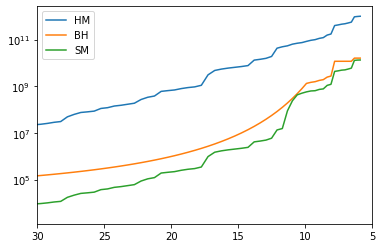

In [74]:
z,times, mass, sm,bh_mass = merged_trees2[10]
plt.figure()
plt.plot(z, mass, label="HM")
plt.plot(z, bh_mass,label="BH")
plt.plot(z, sm, label="SM")
plt.yscale("log")
plt.xlim(30,5)
plt.legend()

[68131.02605863193, 71848.23103140724, 75810.8477404744, 80036.52364355576, 84544.27735829462, 89354.61118136173, 94489.63332146152, 99973.19073188929, 105831.01349403041, 112090.87179933256, 118782.74666647454, 125939.01566340728, 133594.6549811523, 141787.45937705788, 150558.28162531328, 159951.29326552205, 170364.7552512191, 181947.9900843227, 194877.69643186958, 209363.98734327996, 225657.98958068105, 244061.468529722, 264939.1002657009, 288734.22895207413, 315989.24933127075, 347372.177654011, 383711.57532177935, 426042.85020238545, 475670.2071241067, 534250.3443638086, 603906.6975357132, 687387.091114874, 788283.8288951884, 911344.77217332, 1062918.8524714154, 1251603.1609586582, 1489197.089215401, 1792132.1389461933, 2183652.0638180175, 2697199.8416443323, 3381786.7856193366, 4310691.649477998, 5595892.752819356, 7412635.984895227, 10042448.582772138, 13814333.765689738, 19149837.20839313, 26954906.454222165, 38559732.83314815, 56102301.750123926, 83055072.94469574, 125273418.35

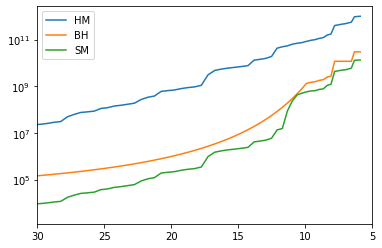

In [73]:
z,times, mass, sm,bh_mass = merged_trees[10]
plt.figure()
plt.plot(z, mass, label="HM")
plt.plot(z, bh_mass,label="BH")
plt.plot(z, sm, label="SM")
plt.yscale("log")
plt.xlim(30,5)
plt.legend()

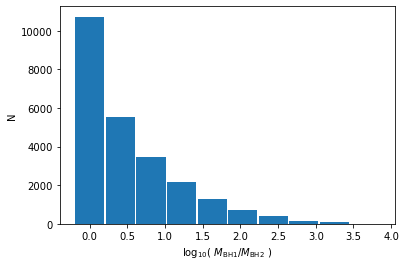

In [41]:
ratios=[]
for pair in bh_mass_ratios:
    l,m=pair[0],pair[1]
    ratios.append(m/l)

a,b,c=plt.hist(np.log10(ratios),align="left", rwidth=0.95)
plt.xlabel(r"${\rm log}_{10}(\ M_{\rm BH1}/M_{\rm BH2}\ )$")
plt.ylabel("N")

plt.savefig("figures/bh_mass_ratio.pdf")

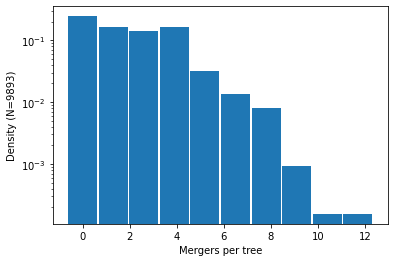

In [26]:
site_nums = [int((f.split("sitenum_")[-1]).split(".c")[0]) for f in all_cand_files]
number_of_mergers = [max(0,m-1) for m in site_nums]
plt.hist(number_of_mergers, log=True,align="left", rwidth=0.95,density=True)
plt.xlabel("Mergers per tree")
plt.ylabel("Density (N="+str(len(number_of_mergers))+")")

plt.savefig("figures/mergers_per_tree.pdf")

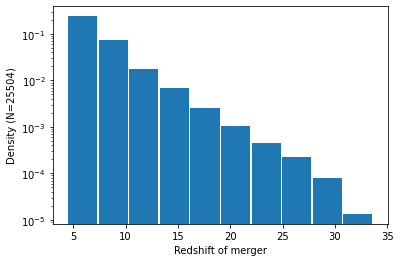

In [22]:
plt.hist(merger_z_combined, log=True,align="left", rwidth=0.95, density=True)
plt.xlabel("Redshift of merger")
plt.ylabel("Density (N="+str(len(merger_z_combined))+")")
plt.savefig("figures/merger_z.pdf")

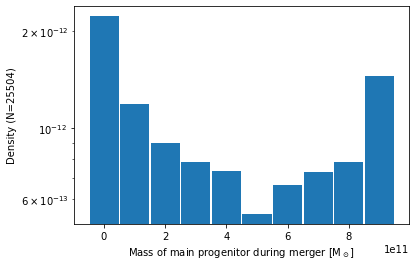

In [24]:
plt.hist(merger_mass_combined, log=True,align="left", rwidth=0.95, density=True)
plt.xlabel(r"Mass of main progenitor during merger [${\rm M}_\odot$]")
plt.ylabel("Density (N="+str(len(merger_mass_combined))+")")
plt.savefig("figures/merger_mass.pdf")

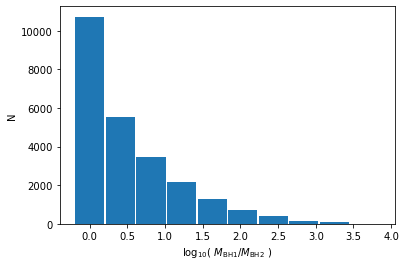

In [41]:
ratios=[]
for pair in bh_mass_ratios:
    l,m=pair[0],pair[1]
    ratios.append(m/l)

a,b,c=plt.hist(np.log10(ratios),align="left", rwidth=0.95)
plt.xlabel(r"${\rm log}_{10}(\ M_{\rm BH1}/M_{\rm BH2}\ )$")
plt.ylabel("N")

plt.savefig("figures/bh_mass_ratio.pdf")

### double checking min mass for H2 collapse

[15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5
 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  29.5] [2927294.835042813, 2821307.6759394705, 2719157.943036019, 2644980.1824277197, 2549214.6544514205, 2479672.8925021603, 2412028.207618007, 2346228.8481422625, 2282224.474186901, 2219966.1191199524, 2159406.1521035675, 2100498.2416539155, 2043197.3201952705, 1987459.549580986, 1951148.3468466164, 1897921.6428391035, 1863246.3119315598, 1812417.5473742394, 1779304.3899185774, 1730765.5341957277, 1699144.172034626, 1668100.537200059, 1622595.2870780872, 1592950.212572123, 1563846.7583022479, 1535275.0287804212, 1507225.3093107555, 1479688.0626863963, 1452653.9259467812, 1426113.7071941297]


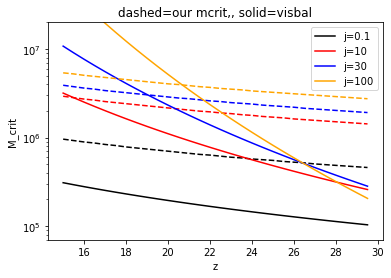

In [81]:
SHIELD = False
LW_INIT = True

plt.figure()
plt.yscale("log")
plt.ylim(7e4,2e7)
z_list = np.arange(15,30,0.5)
for j, c in zip([0.1,10,30,100],["black", "red", "blue", "orange"]):
    mcrit_list = mcrit_visbal(j,0,z_list)
    m_crits = []
    for z in z_list: m_crits.append(get_mcrit(z,j))
    plt.plot(z_list, mcrit_list,label="j="+str(j),color=c)
    plt.plot(z_list, m_crits, ls="--",color=c)
    if(j==10): print(z_list, m_crits)
plt.legend()
plt.ylabel("M_crit")
plt.title("dashed=our mcrit,, solid=visbal")
plt.xlabel("z")
plt.savefig("Mcrits_shield=off.pdf")

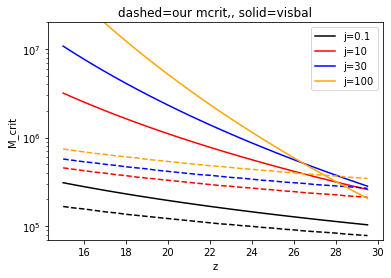

In [70]:
SHIELD = True
LW_INIT = False

plt.figure()
plt.yscale("log")
plt.ylim(7e4,2e7)
z_list = np.arange(15,30,0.5)
for j, c in zip([0.1,10,30,100],["black", "red", "blue", "orange"]):
    mcrit_list = mcrit_visbal(j,0,z_list)
    m_crits = []
    for z in z_list: m_crits.append(get_mcrit(z,j))
    plt.plot(z_list, mcrit_list,label="j="+str(j),color=c)
    plt.plot(z_list, m_crits, ls="--",color=c)
plt.legend()
plt.ylabel("M_crit")
plt.title("dashed=our mcrit,, solid=visbal")
plt.xlabel("z")
plt.savefig("Mcrits_shield=on_LW_init=off.pdf")

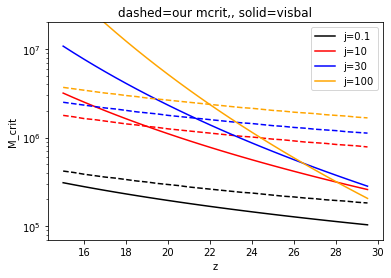

In [71]:
SHIELD = True
LW_INIT = True

plt.yscale("log")
plt.ylim(7e4,2e7)
z_list = np.arange(15,30,0.5)
for j, c in zip([0.1,10,30,100],["black", "red", "blue", "orange"]):
    mcrit_list = mcrit_visbal(j,0,z_list)
    m_crits = []
    for z in z_list: m_crits.append(get_mcrit(z,j))
    plt.plot(z_list, mcrit_list,label="j="+str(j),color=c)
    plt.plot(z_list, m_crits, ls="--",color=c)
plt.legend()
plt.ylabel("M_crit")
plt.title("dashed=our mcrit,, solid=visbal")
plt.xlabel("z")
plt.savefig("Mcrits_shield=on_LW_init=on.pdf")

<ipython-input-112-00a33f1e94d7>:56: RuntimeWarning: divide by zero encountered in true_divide
  n_h2 = k9*n_H*n_e/k_LW
<ipython-input-112-00a33f1e94d7>:56: RuntimeWarning: divide by zero encountered in true_divide
  n_h2 = k9*n_H*n_e/k_LW
<ipython-input-112-00a33f1e94d7>:56: RuntimeWarning: divide by zero encountered in true_divide
  n_h2 = k9*n_H*n_e/k_LW
<ipython-input-112-00a33f1e94d7>:56: RuntimeWarning: divide by zero encountered in true_divide
  n_h2 = k9*n_H*n_e/k_LW


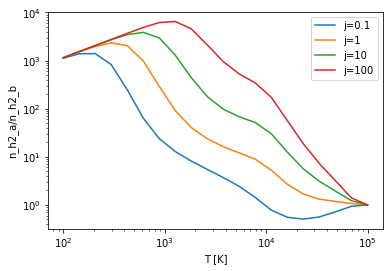

In [119]:
m,z = 1e8,10
T_list = np.logspace(2,5,20)

for j in [0.1, 1, 10, 100]:
    n1 = calc_n_h2(j,T_list, m,z)
    n2 = calc_n_h2(j,T_list, m,z)
    plt.plot(T_list, n1/n2, label="j="+str(j))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("T [K]")
plt.ylabel("n_h2_a/n_h2_b")

plt.legend()
plt.savefig("figures/calc_nh2_ratio.pdf")
print()

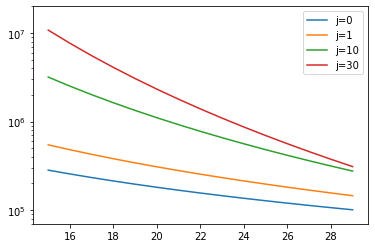

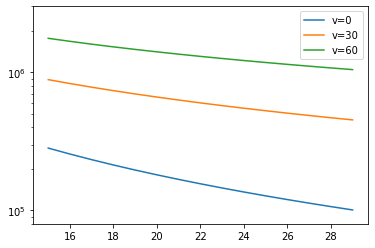

In [120]:


plt.figure()
plt.yscale("log")
plt.ylim(7e4,2e7)
z_list = np.arange(15,30,1)
for j in [0,1,10,30]:
    mcrit_list = mcrit_visbal(j,0,z_list,)
    plt.plot(z_list, mcrit_list,label="j="+str(j))
plt.legend()

    
    
plt.figure()
plt.yscale("log")
plt.ylim(8e4,3e6)
z_list = np.arange(15,30,1)
for v in [0,30,60]:
    mcrit_list = mcrit_visbal(0,v,z_list,)
    plt.plot(z_list, mcrit_list,label="v="+str(v))
plt.legend()
    

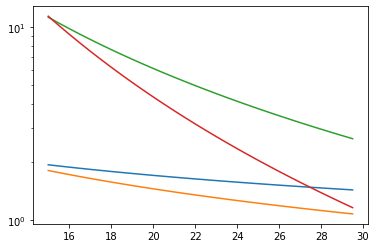

In [74]:
plt.plot(z_list,  mcrit_visbal(1,0,z_list)/mcrit_visbal(0,0,z_list))
plt.plot(z_list,  mcrit_visbal(1,30,z_list)/mcrit_visbal(0,30,z_list))
plt.plot(z_list,  mcrit_visbal(10,0,z_list)/mcrit_visbal(0,0,z_list))
plt.plot(z_list,  mcrit_visbal(10,30,z_list)/mcrit_visbal(0,30,z_list))
plt.yscale("log")



# Checking stellar mass calc

Text(0, 0.5, 'm_star')

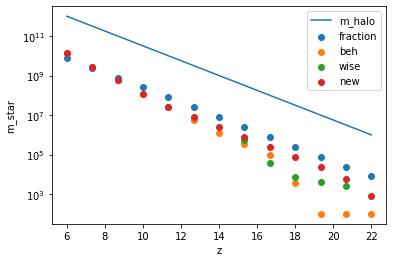

In [8]:
m = mm_mass
z = mm_z
t = mm_time

m = np.power(10,(np.arange(6,12.5,0.5)))
z = np.linspace(6,22, len(m))[::-1]
t = z_to_time(z)

z_wise, m_halo, m_star = calc_mass_wise(z,m)

stellar_mass2 = calc_mass(m,z,t)
plt.scatter(z, m*(OMEGA_B/OMEGA_M)*0.05, label="fraction")
plt.scatter(z, calc_mass_beh_2019(m,z), label="beh")
plt.scatter(z_wise, m_star, label="wise")
plt.scatter(z, stellar_mass2, label="new")

plt.plot(z, m, label="m_halo")
plt.yscale("log")
plt.legend()
plt.xlabel("z")
plt.ylabel("m_star")
#plt.savefig("figures/mass_comp.pdf")

tree_test = all_trees[100]
z =tree_test[0]
t = tree_test[1]
m = tree_test[2]
z_wise, m_halo, m_star = calc_mass_wise(z,m)

stellar_mass2 = calc_mass(m,z,t)
plt.scatter(z, m*(OMEGA_B/OMEGA_M)*0.005, label="fraction")
plt.scatter(z, calc_mass_beh_2019(m,z), label="beh")
plt.scatter(z_wise, m_star, label="wise")
plt.scatter(z, stellar_mass2, label="new")

plt.plot(z, m, label="m_halo")
plt.yscale("log")
plt.legend()
plt.xlabel("z")
plt.ylabel("m_star")
#plt.savefig("figures/mass_comp.pdf")

plt.scatter(m, m*(OMEGA_B/OMEGA_M)*0.05, label="fraction")
plt.scatter(m, calc_mass_beh_2019(m,z), label="beh")
plt.scatter(m_h, m_star, label="wise")

#plt.plot(z, m, label="halo")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("m_halo")
plt.ylabel("m_star")
plt.legend()
plt.savefig("figures/mass_comp2.pdf")

# Plotting

In [92]:

def find_ratio_lifetime_merged(all_trees_raw,tau_fold,f_cap, ratio_min = 1e-1, total_time = False,edd_growth=True, optimistic=True):
    dt_arr = []
    taus = []
    
    merged_trees = evolve_BH_with_mergers(all_trees_raw, tau=tau_fold, cap=f_cap, optimistic=optimistic)[0]
    for t in merged_trees:
        redshift, time,halo_mass = t[0],t[1],t[2]
        stellar_mass = t[3]
        tau = time[-1]-time[0]
        taus.append(tau)
        bh_mass = t[4]
        
        t0 = time[0]
        if(not total_time):
            dt = time[-1] - t0 
            for x in range(len(time)):
                if(bh_mass[x]/stellar_mass[x] < ratio_min): 
                    dt = time[x]-t0
                    break
        if(total_time):
            dt =0
            for x in range(1,len(time)):
                if(bh_mass[x-1]/stellar_mass[x-1] > ratio_min): dt += time[x]-time[x-1]

        dt_arr.append(dt)

    dt_arr = np.array(dt_arr)
    return dt_arr, taus

0.0
0.004166666666666667
0.008333333333333333
0.0125
0.016666666666666666
0.020833333333333332
0.025
0.029166666666666667
0.03333333333333333
0.0375
0.041666666666666664
0.04583333333333333
0.05
0.05416666666666667
0.058333333333333334
0.0625
0.06666666666666667
0.07083333333333333
0.075
0.07916666666666666
0.08333333333333333
0.0875
0.09166666666666666
0.09583333333333334
0.1
0.10416666666666667
0.10833333333333334
0.1125
0.11666666666666667
0.12083333333333333
0.125
0.12916666666666668
0.13333333333333333
0.1375
0.14166666666666666
0.14583333333333334
0.15
0.15416666666666667
0.15833333333333333
0.1625
0.16666666666666666
0.17083333333333334
0.175
0.17916666666666667
0.18333333333333332
0.1875
0.19166666666666668
0.19583333333333333
0.2
0.20416666666666666
0.20833333333333334
0.2125
0.21666666666666667
0.22083333333333333
0.225
0.22916666666666666
0.23333333333333334
0.2375
0.24166666666666667
0.24583333333333332
0.25
0.25416666666666665
0.25833333333333336
0.2625
0.26666666666666666

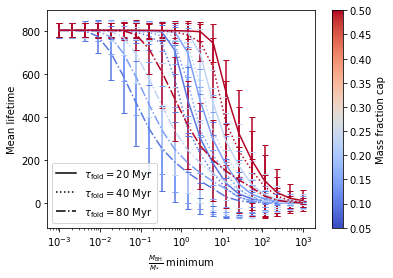

In [110]:
ratio_list = np.logspace(-3,3, 20)

cap_list = [0.05,0.5]
folding_list = [20,80]

cap_list = [0.05,0.1,0.2,0.5]
folding_list = [20,40,80]
ls_list = ["-",":", "-."]
label_list = []
for f in folding_list: label_list.append(r"$\tau_{\rm fold}{=}$"+str(f)+" Myr")

plt.figure()
plt.xscale("log")
plt.xlabel(r"$\frac{M_{\rm BH}}{M_*}$ minimum")
plt.ylabel("Mean lifetime")
i=0
total_its = len(ratio_list)*len(cap_list)*len(folding_list)
for c in cap_list:
    for t, ls in zip(folding_list, ls_list):
        mean_list = []
        std_list =[]
        for ratio in ratio_list:
            dt, total_times = find_ratio_lifetime_merged(all_trees_raw, t,c,ratio_min = ratio,total_time=True)
            mean_list.append(np.mean(dt))
            std_list.append(np.std(dt))
            print(i/(total_its))
            i+=1
        plt.errorbar(ratio_list, mean_list,yerr=std_list, ls=ls, color=CMAP(c/0.5),capsize=3)
        
for x in range(len(ls_list)): plt.plot(1,1, ls=ls_list[x], label=label_list[x],color="black")
plt.scatter(np.linspace(1,1,len(cap_list)), np.linspace(0,1,len(cap_list)), c= cap_list,cmap=CMAP,s=0)
plt.colorbar(label="Mass fraction cap")
plt.legend()

plt.savefig("mean_lifetime_vs_ratio.pdf")


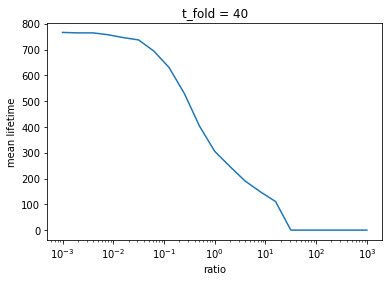

In [246]:
#plt.plot(ratio_list, mean_list)
plt.errorbar(ratio_list, mean_list,yerr=std_list)
plt.xscale("log")
plt.xlabel("ratio")
plt.ylabel("mean lifetime")
plt.title("t_fold = 40")
plt.savefig("mean_lifetime_vs_ratio_tau40.pdf")

In [245]:
z_av,bh_avs,bh_std, sm_avs, sm_std = find_averages(all_trees)

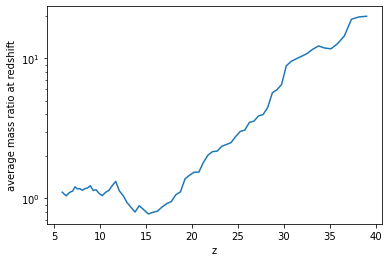

In [249]:
plt.plot(z_av[::-1], bh_avs/sm_avs)
plt.yscale("log")
plt.xlabel("z")
plt.ylabel("average mass ratio at redshift")
plt.savefig("figures/av_ratio_vs_z.pdf")

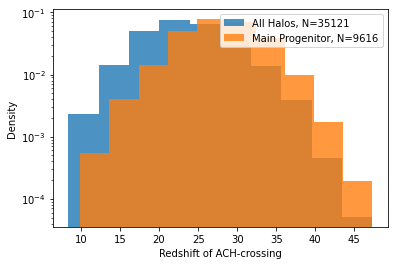

In [43]:
init_z = [tree[0][0] for tree in all_trees]
init_z_main = [tree[2][0] for tree in merged_trees]
plt.hist(init_z, log=True, density=True, label="All Halos, N="+str(len(init_z)),alpha=0.8)
plt.hist(init_z_main, log=True, density=True, label="Main Progenitor, N="+str(len(init_z_main)),alpha=0.8)
plt.xlabel("Redshift of ACH-crossing")
plt.ylabel("Density")
plt.legend()
plt.savefig("figures/z_hist.pdf")

C:\Users\Matthew\AppData\Local\Temp/ipykernel_41068/3724827236.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hm = np.array([t[2][::-1] for t in all_trees])


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


C:\Users\Matthew\AppData\Local\Temp/ipykernel_41068/3724827236.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("mass_vs_redshift.pdf")
C:\Users\Matthew\AppData\Local\Temp/ipykernel_41068/3724827236.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("mass_vs_redshift.pdf")
C:\Users\Matthew\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


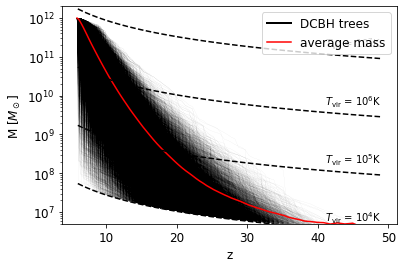

In [77]:
plt.rcParams.update({'font.size': 12})

hm = np.array([t[2][::-1] for t in all_trees])
lengths = np.array([np.size(b) for b in hm])
av_hm = []
for x in range(np.max(lengths)):
    filter_ = np.where(x<lengths)
    hm_temp = hm[filter_]
    hms = [a[x] for a in hm_temp]
    av_hm.append(np.mean(hms))
av_hm=np.array(av_hm)
z_av,time_av = all_trees[np.argmax(lengths)][0][::-1], all_trees[np.argmax(lengths)][1]

plt.figure()
plt.plot([20,20.1], [1e8,1e8], label="DCBH trees", lw=2, c="black")

i=0
for t in all_trees:
    plt.plot(t[0],t[2],c="black", alpha=0.2,lw=0.1)
    i+=1
    if(i%1000 ==0): 
        print(i)

plt.plot(z_av,av_hm, label="average mass", c="red")

z_range = np.arange(6,50)
for T in [1e4,1e5,1e6,1e7]:
    mass_range = T_vir_inverted(T,z_range)
    plt.plot(z_range, mass_range, color="black", ls="--")
    txt = "10^"+str(np.log10(T))[0]
    plt.text(45,mass_range[-1]*2.5,r"$T_{\rm vir}$ = $"+txt+"$K", horizontalalignment='center',verticalalignment='center',fontsize=10)

plt.yscale("log")
plt.ylim(5e6,2e12)

plt.legend()
plt.yscale("log")
plt.xlabel("z")
plt.ylabel(r"M $[M_\odot]$")
plt.savefig("figures/mass_vs_redshift.pdf")

In [44]:
def find_averages(all_trees):
    
    all_bh_mass = np.array([t[4][::-1] for t in all_trees])
    all_sm = np.array([t[3][::-1] for t in all_trees])
    lengths = np.array([np.size(b) for b in all_bh_mass])
    bh_avs, bh_std = [], []
    sm_avs, sm_std = [], []
    for x in range(np.max(lengths)):
        filter_ = np.where(x<lengths)
        bh_temp = all_bh_mass[filter_]
        sm_temp = all_sm[filter_]
        bhs = [bh_temp_it[x] for bh_temp_it in bh_temp]
        bh_avs.append(np.mean(bhs))
        bh_std.append(np.std(bhs))
        sms = [sm_temp_it[x] for sm_temp_it in sm_temp]
        sm_avs.append(np.mean(sms))
        sm_std.append(np.std(sms))
    bh_avs,bh_std, sm_avs, sm_std = np.array(bh_avs), np.array(bh_std), np.array(sm_avs), np.array(sm_std)
    z_av,time_av = all_trees[np.argmax(lengths)][0], all_trees[np.argmax(lengths)][1]
    return z_av,bh_avs,bh_std, sm_avs, sm_std

C:\Users\Matthew\AppData\Local\Temp/ipykernel_41068/545599717.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_bh_mass = np.array([t[4][::-1] for t in all_trees])
C:\Users\Matthew\AppData\Local\Temp/ipykernel_41068/545599717.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_sm = np.array([t[3][::-1] for t in all_trees])


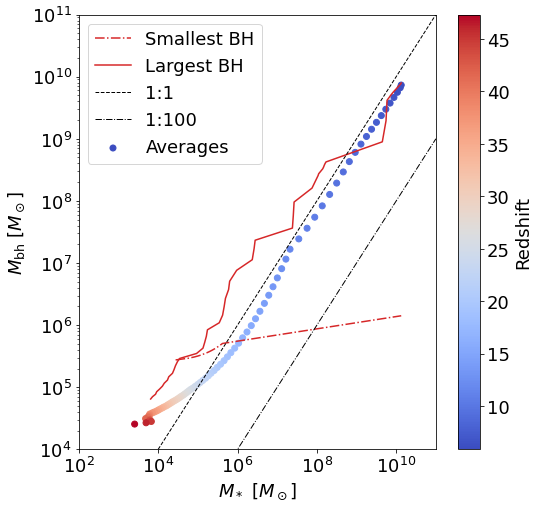

In [83]:
plt.rcParams.update({'font.size': 18})
SUPER=False

plt.figure(figsize=(8,8))
plt.xlabel(r"$M_* \ [M_\odot]$")
plt.ylabel(r"$M_{\rm bh} \ [M_\odot]$")
plt.yscale("log")
plt.ylim(1e4,1e11)
plt.xscale("log")
plt.xlim(1e2,1e11)

least_massive_sm, least_massive_bh, most_massive_sm, most_massive_bh = find_min_max_bh(all_trees, SUPER=SUPER)


z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees)

plt.plot(least_massive_sm, least_massive_bh, color = "tab:red", label="Smallest BH", ls ="-.")
plt.plot(most_massive_sm, most_massive_bh, color = "tab:red", label="Largest BH")

#plt.errorbar(sm_av, bh_av, yerr=bh_std, xerr=sm_std , color="tab:red")
plt.scatter(sm_av, bh_av , c=z[::-1], label="Averages", cmap=CMAP)

plt.plot([1e4,1e11], [1e4,1e11], ls="--", label = "1:1", color="black",lw=1)
plt.plot([1e4,1e11], [1e2,1e9], ls="-.", label = "1:100", color="black",lw=1)

plt.colorbar(label="Redshift")
plt.legend()
save_title="bh_mass_vs_stellar_mass_super="+str(SUPER)
plt.savefig("figures/"+save_title+".pdf",bbox_inches='tight')

In [55]:
len(merged_trees)

9616

100000.0 0 0
100000.0 1 0
100000.0 2 0
100000.0 0 1
100000.0 1 1
100000.0 2 1
100000.0 0 2
100000.0 1 2
100000.0 2 2
100000.0 0 3
100000.0 1 3
100000.0 2 3


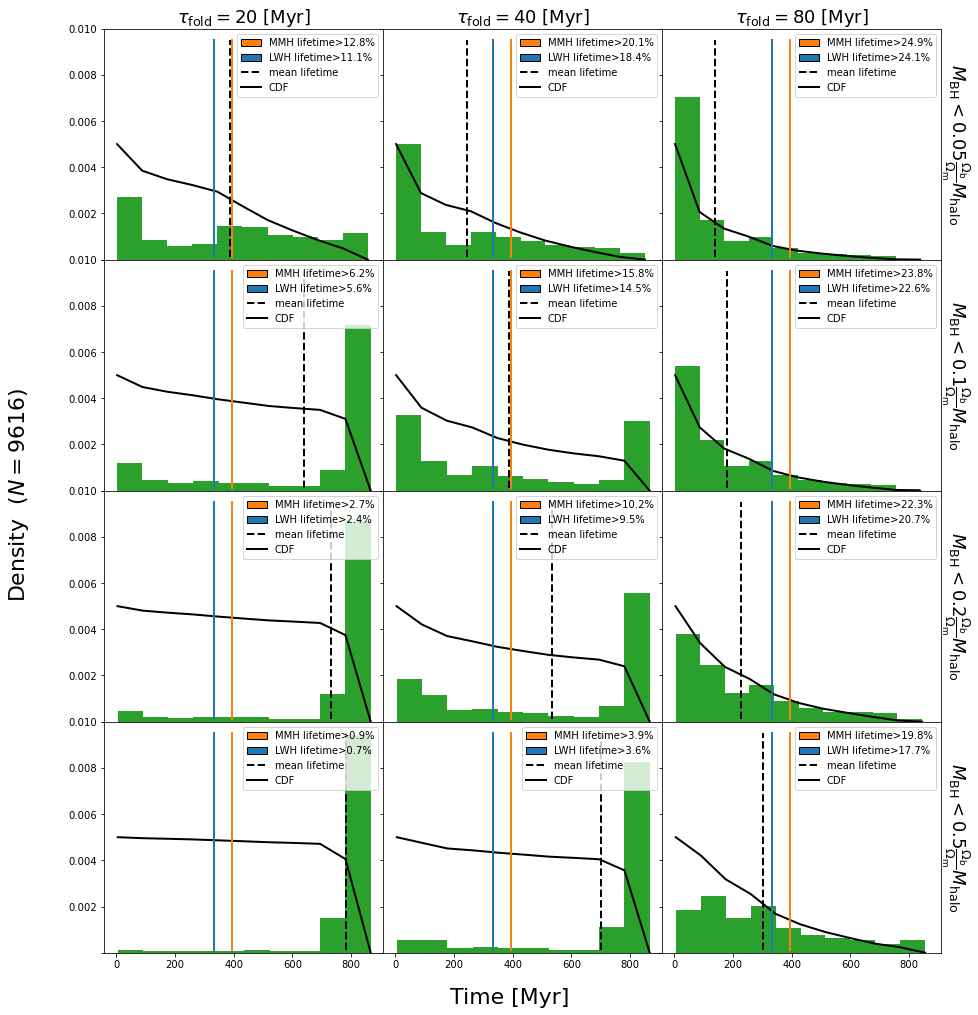

In [58]:
OPTIMISTIC = True
ratio_min = 1e-0
total_time = False
edd_growth = False
cap_list = [0.05,0.1,0.2,0.5]
#seed_list = [1e4,1e5,1e6]
seed_list = [1e5]
folding_list = [20,40,80]
x_num = len(folding_list)
y_num = len(cap_list)
colors= ["tab:green","tab:blue","tab:orange"]


fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=True, figsize=(15,17))
fig.supxlabel("Time [Myr]", y=0.08, size=22)
fig.supylabel(r"Density  $(N="+str(len(merged_trees))+")$", x=0.035, size=22)

y_axis_max = 0.01
for axis in axs.ravel(): 
    try: plt.setp(axis.get_yticklabels()[0], visible=False)
    except: continue
    axis.set_ylim(0,y_axis_max)

# fig.supxlabel("Lifetime [Myr]", y=0.08, size=22)
# fig.supylabel("Density for N="+str(len(all_trees)), x=0.04, size=22)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,colors):
            print(seed, col, row)
            
            mm_lifetime,mm_total_times = find_ratio_lifetime([mm_tree],folding_list[col],cap_list[row],seed, ratio_min = ratio_min, total_time = total_time,edd_growth=edd_growth)
            lw_lifetime,lw_total_times = find_ratio_lifetime([lw_tree],folding_list[col],cap_list[row],seed, ratio_min = ratio_min, total_time = total_time,edd_growth=edd_growth)
            dt, total_times = find_ratio_lifetime_merged(all_trees_raw, folding_list[col],cap_list[row],seed,ratio_min = ratio_min, total_time = total_time, edd_growth=edd_growth, optimistic=OPTIMISTIC)            
            
            n, bins, patches = axs[row,col].hist(dt,alpha=1, color="tab:green", density=True)
            labels,handles = [],[]
            meanlt = np.mean(dt)
            axs[row,col].plot(np.linspace(meanlt,meanlt,10),np.linspace(y_axis_max*0.01,y_axis_max*0.95,10),c="black", lw=2, ls="--")
            pdf = list(n / sum(n))
            pdf.insert(0,0)
            cdf = (1-np.cumsum(pdf))*y_axis_max
            axs[row,col].plot(bins[0:], cdf, label="CDF", c="black", lw=2)
            
            if(mm_lifetime[0] != mm_total_times[0]): 
                axs[row,col].plot(np.linspace(mm_lifetime,mm_lifetime,10),np.linspace(y_axis_max*0.01,y_axis_max*0.95,10),c="tab:orange", lw=2)
                mm_fraction = len(np.where(dt < mm_lifetime)[0])/len(all_trees)
                handles.append(Rectangle((0, 0), 1, 1, color="tab:orange", ec="k"))
                labels.append("MMH lifetime>"+"{:.1f}".format(mm_fraction*100)+"%")

            if(lw_lifetime[0] != lw_total_times[0]): 
                axs[row,col].plot(np.linspace(lw_lifetime,lw_lifetime,10),np.linspace(y_axis_max*0.01,y_axis_max*0.95,10),c="tab:blue", lw=2)
                lw_fraction = len(np.where(dt < lw_lifetime)[0])/len(all_trees)
                handles.append(Rectangle((0, 0), 1, 1, color="tab:blue", ec="k"))
                labels.append("LWH lifetime>"+"{:.1f}".format(lw_fraction*100)+"%")
            
            handles.append(Line2D([0], [0], color="black",lw=2, ls="--"))
            handles.append(Line2D([0], [0], color="black",lw=2))
            
            handles.append(Rectangle((0, 0), 1, 1, color="tab:blue", ec="k"))
            labels.append("mean lifetime")
            labels.append("CDF")
            if(labels != []): axs[row,col].legend(handles, labels,loc='upper right', fontsize=10)

        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
# handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
# labels = [r'$M_0$ = $10^'+str(int(np.log10(mass)))+'$ $M_{\odot}$' for mass in seed_list]
# axs[0, 2].legend(handles, labels,loc='upper left', fontsize = 14 , bbox_to_anchor=(0.2, 0.90),edgecolor="black", framealpha=1)       
plt.subplots_adjust(wspace=0, hspace=0)
save_title = "lifetimes_for_ratio_min="+str(ratio_min)+"_total_time="+str(total_time)+"_edd_growth="+str(edd_growth)+"_opt="+str(OPTIMISTIC)
plt.savefig("figures/"+save_title+".pdf",bbox_inches='tight')

# Graveyard

In [66]:
points = np.array([z_jlw,m_jlw]).T
values = jlw
grid_jlw = griddata(points, values, (zs, ms), method='nearest')
print(grid_z0*J_21*V_MEAN)

[1.89313082e-04 1.81007773e-04 1.81007773e-04 1.81007773e-04
 1.81007773e-04 2.09941432e-04 2.09941432e-04 2.09941432e-04
 2.09941432e-04 2.09941432e-04 2.09941432e-04 8.11341782e-05
 8.21536024e-05 8.21536024e-05 8.21536024e-05 1.83826181e-04
 1.71113361e-04 8.21536024e-05 8.21536024e-05 8.21536024e-05
 8.21536024e-05 8.21536024e-05 8.21536024e-05 8.21536024e-05
 8.21536024e-05 8.21536024e-05 8.21536024e-05 8.42824001e-05
 8.42824001e-05 8.42824001e-05 8.42824001e-05 8.42824001e-05
 8.42824001e-05 8.42824001e-05 8.42824001e-05 8.42824001e-05
 8.42824001e-05 8.42824001e-05 8.42824001e-05 8.42824001e-05
 8.42824001e-05 8.82101819e-05 8.82101819e-05 8.82101819e-05
 8.82101819e-05 8.82101819e-05 8.82101819e-05 8.82101819e-05
 8.82101819e-05 8.82101819e-05 8.82101819e-05 8.82101819e-05
 8.82101819e-05 8.82101819e-05 8.82101819e-05 8.82101819e-05
 8.82101819e-05 8.82101819e-05 8.82101819e-05 8.82101819e-05
 8.82101819e-05]


In [137]:
a=poisson.rvs(1.358e-04,size=100000)
print(np.any(a>0))

True


In [13]:

F = 0.38
sig_LW = 0.5
L = 2.8

def L_prob(L, r):
    return np.power(10, np.log10(F*L) + sig_LW*np.sqrt(2)*special.erfinv(2*r-1)  )


def L_26(m,z):
    return 2.8*m/1e8*np.power((1+z)/11.0,-1.5)


def L_lw2(m, z):
    a = 12.4/2.4
    h = 6.626e-27 
    #t = 83*np.float_power((1+z)/11,-3/2) #myr
    t = 18*np.float_power((1+z)/31,-3/2) #myr
    Q_lw = 1e47*np.float_power(1+t/4,-3/2)*np.exp(-t/300)
    f_esc = 1
    m_star = 0.05*OMEGA_B/OMEGA_M * m
    return a*h*Q_lw * f_esc * m_star



def photodissociation_rate(j_lw):
    return 1.39e-12*j_lw


In [42]:
#factor of 0.1????
df = pd.read_csv("j_files/z_10.067089m_pow_7.000000Mrbins.txt", delim_whitespace=True)
df
j_bins, n_bins, m_bins = df["J21_mean"],df["N_mean"],df["M2_Ms"]
z=10.067089
J_mean = np.sum(n_bins*j_bins)


J_list4 = []
for x in range(10000):
    J=0
    if(x%1000==0):print(x)
        
    N_halos_poisson = poisson.rvs(n_bins) 
    
    for i in range(len(j_bins)):

        N_halos = N_halos_poisson[i]

        if(N_halos >= 10): J+= N_halos*j_bins[i]
        else:
            for n in range(N_halos):
                r = random.uniform(0, 1)
                if(r>0.1):
                    L = L_26(m_bins[i],z) 
                    new_L = L_prob(L, r)
                    c = new_L*1e26/L_lw2(m_bins[i],z)
                    J += c*j_bins[i]
    J_list4.append(J)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


(array([8.515e+03, 1.283e+03, 1.420e+02, 3.400e+01, 1.700e+01, 4.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 60.11498242,  72.22219487,  84.32940733,  96.43661979,
        108.54383225, 120.65104471, 132.75825716, 144.86546962,
        156.97268208, 169.07989454, 181.187107  ]),
 <BarContainer object of 10 artists>)

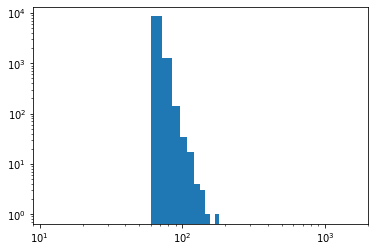

In [43]:
plt.xscale('log')
#plt.xticks([10,100,1000])
plt.xlim(9,2000)
plt.hist(J_list4, log=True)

### Power spectrum P(k)

In [24]:
E = 2.7182818
k0 = 100
nspec = 1
Omega_M0 = OMEGA_M
xhubble = 0.71
Omega_Baryon0_h2 = 0.022981 
Omega_Baryon0 = Omega_Baryon0_h2/xhubble/xhubble 
f_bar = Omega_Baryon0/Omega_M0 
f = Omega_M0 * xhubble*xhubble 

bb1 = 0.313 * np.power(f, -0.419) * (1.0 + 0.607*np.power(f, 0.674)) 
bb2 = 0.238 * np.power(f, 0.223) 

bnode = 8.41* np.power(f, 0.435) 

keq = 7.46e-2 * f 
ksilk = 1.6 * np.power(Omega_Baryon0_h2, 0.52) * np.power(f, 0.73) * (1.0 + np.power(10.4*f,-0.95)) 

zeq = 2.5e+4 * f 
zd = 1291.0 * np.power(f, 0.251)/(1.0 + 0.659*np.power(f, 0.828)) * (1.0 + bb1 * np.power(Omega_Baryon0_h2, bb2)) 
y = ((1.0+zeq)/(1.0+zd)) 
Fy = np.log((np.sqrt(1.0+y) + 1.0) / (np.sqrt(1.0+y) - 1.0)) 
Gy = y * (-6.0 * np.sqrt(1.0+y) + (2.0+3.0*y) * Fy) 

Req = 31.5 * Omega_Baryon0_h2 * (1000.0/zeq) 
Rd  = 31.5 * Omega_Baryon0_h2 * (1000.0/zd) 

sEH = (2.0/(3.0*keq)) * np.sqrt(6.0/Req) * np.log((np.sqrt(1.0+Rd) + np.sqrt(Rd+Req))/(1.0+np.sqrt(Req))) 

a1 = np.power(46.9*f, 0.670) * (1.0 + np.power(32.1*f, -0.532)) 
a2 = np.power(12.0*f, 0.424) * (1.0 + np.power(45.0*f, -0.582)) 
b1 = 0.944 / (1.0+np.power(458.0*f, -0.708)) 
b2 = np.power(0.395*f, -0.0266) 

alpha_c = np.power(a1, -f_bar) * np.power(a2, -(f_bar*f_bar*f_bar)) 
beta_c = 1.0 + b1*(np.power((Omega_M0-Omega_Baryon0)/Omega_M0, b2) - 1.0) 
beta_c = 1.0/beta_c 

alpha_b = 2.07 * keq * sEH * np.power(1.0+Rd, -0.75) * Gy 
beta_b = 0.5 + f_bar + (3.0-2.0*f_bar) * np.sqrt(np.power(17.2*f, 2) + 1.0) 

def ps(k):
    #Eisenstein and hu power spectrum
    q = k/(13.41*keq) 

    silk = np.power(k/ksilk,1.4) 
    silk = np.exp(-silk) 
    stilde = sEH/np.power(1.+np.power(bnode/(k*sEH), 3),0.3333) 

    fff = 1.0/(1.0 + np.power(k*sEH/5.4, 4)) 
    C1 = 14.2 + 386.0/(1.0+69.0*np.power(q,1.08)) 
    C2 = 14.2/alpha_c + 386.0/(1.0 + 69.9*np.power(q,1.08)) 

    t11 = np.log(E + 1.8*beta_c*q) 
    t12 = np.log(E + 1.8*q) 

    t1 = t11/(t11 + C1*q*q) 
    t2 = t11/(t11 + C2*q*q) 
    t3 = t12/(t12 + C1*q*q) 

    tb1 = t3/( 1.0 + np.power(k*sEH/5.2, 2)) 
    tb2 = (alpha_b/(1.0 + np.power(beta_b/(k*sEH), 3))) *silk 

    T_c = fff*t1 + (1.-fff)*t2 
    T_b = (tb1 + tb2) * np.sin(k*stilde)/(k*stilde) 

    tk = (Omega_Baryon0/Omega_M0)*T_b + (Omega_M0-Omega_Baryon0)/Omega_M0 * T_c     
    ps = tk*tk*np.power(k/k0, nspec)
    return ps


### Sigma(R)

In [82]:
fit = np.array([ 7.23044138e-08,  3.21327949e-07, -2.43937475e-06, -1.17134669e-05,
        3.47827840e-05,  1.91326970e-04, -2.58320202e-04, -1.99347063e-03,
        1.49546231e-04,  1.50008545e-02,  3.11224716e-02,  7.47393142e-03,
       -1.77188289e+00,  6.96414211e+00, -1.06901188e+01,  6.04845802e+00])
p = np.poly1d(fit)

def sigma_fit(r):
    sigma = p(np.log10(r))
    if(sigma <= 0): return 1e-5
    return sigma

In [172]:
s8 = 1.2185022005753475e-08
#s8 = 1.9456152464654926e-08
SIG_FIT = False
def get_sigma(R):
    if(SIG_FIT): return sigma_fit(R)
    else: return sigma(R)/s8*SIGMA_8

def sigma(R):
    return quad(sigma_int, 0, np.inf, args=(R), maxp1=200, epsabs=1e-14,limit=1000)[0]

def sigma_int(k,R):
    return np.power(k,2)*ps(k)*W(k*R)*W(k*R)

def W(x):
    return 3*(np.sin(x)/x - np.cos(x))/(np.power(x,2))

def m_to_r(m):
    rho_crit = 1.5*1e-7*1e18
    rho_crit = rho_crit*OMEGA_M
    r = np.power((3.*m)/(4.*np.pi*rho_crit), 1./3)
    return r

Text(0.5, 0, 'Mass $[M_\\odot]$')

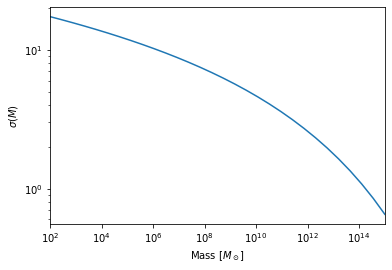

In [173]:
mass_list = np.power(10, np.linspace(2,15,30))
r_list = m_to_r(mass_list)
sigma_list = []
for r in r_list:
    sigma_list.append(np.sqrt(get_sigma(r)))
plt.plot(mass_list, sigma_list)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e2,1e15)
plt.ylabel(r"$\sigma(M)$")
plt.xlabel(r"Mass $[M_\odot]$")

This agrees with Fig 5 of https://arxiv.org/pdf/astro-ph/0010468.pdf, so I think my sigma calculation is good to go.

### Linear bias

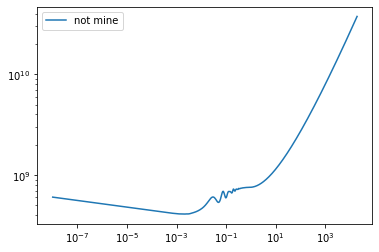

In [99]:
mf = MassFunction()
plt.plot(mf.k, mf.power/ps(mf.k), label="not mine")
#plt.plot(mf.k, ps(mf.k), label="mine")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [132]:
def W(x):
    return 3*(np.sin(x)/x - np.cos(x))/(np.power(x,2))



def linear_bias(d,r1,r2):  
#     r1 = m_to_r(m1)
#     r2 = m_to_r(m2)
    r_max = max(r1,r2)
    A = 0
    A += quad(linear_bias_int, 0, 10, args=(d,r_max),epsabs=1e-12, limit=500)[0]
    A += quad(linear_bias_int, 10,20, args=(d,r_max),epsabs=1e-12, limit=500)[0]
    A += quad(linear_bias_int, 20,np.inf, args=(d,r_max),epsabs=1e-12, limit=2000)[0]
    #return 1/s8*SIGMA_8 * A
    return 1/s8*SIGMA_8 * A


def linear_bias_int(k,d,r_max):
    return k*np.sin(k*d)/(d)*ps(k)*W(k*r_max)*W(k*r_max)

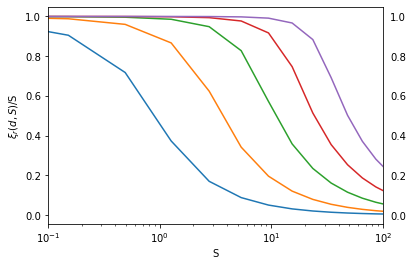

In [189]:
plt.figure()
plt.xscale("log")
plt.xlim(0.1,100)
plt.ylabel(r"$\xi_r(d,S)$/S")
plt.xlabel("S")
plt.tick_params(labelright=True,right=False)
for d in [10,3.3,1,0.33,0.1]:
    e_list, sigma_list,r_list = [],[],[]
    for masspow in range(4,18,1):
        mass = np.float_power(10,masspow)
        e_list.append(linear_bias(d,m_to_r(mass),m_to_r(mass)))
        sigma_list.append(get_sigma(m_to_r(mass)))
    sigma_list = np.array(sigma_list)
    e_list = np.array(e_list)
    plt.plot(sigma_list, e_list/sigma_list)

A great match with the bottom panel of Fig 1 from https://arxiv.org/pdf/astro-ph/0205276.pdf, linear bias is good to go. Though, I had to remove the 1/2pi^2 factor from the linear bias. I think this makes sense given the way I've normalized the powerspectrum. It also slightly disagrees with Fig1 for large S ( by a factor of 0.2ish)

### Non-linear bias

In [191]:
def omega_z(z):
    return OMEGA_M*np.power(1+z, 3)/(OMEGA_L + OMEGA_M*np.power(1+z, 3))

def omega_l(z):
    return OMEGA_L/(OMEGA_L + OMEGA_M*np.power(1+z, 3))


def gg(z):
    omegaz = omega_z(z)
    omegal = omega_l(z)
    return 5 * omegaz / 2 / (np.power(omegaz, 4/7) - omegal + (1+omegaz/2)*(1+omegal/70))

def D(z):
    return gg(z)/gg(0)/(z+1)

def get_v(z):
    return delta_c/D(z)

def m_to_r(m):
    rho_crit2 = 1.5*1e-7*1e18
    r = np.power((3.*m)/(4.*np.pi*rho_crit2*OMEGA_M), 1./3)
    return r

def G_q(d,e):
    return 1/np.sqrt(2*np.pi*e)*np.exp(-d*d/(2*e))

def H(x):
    if(x>0): return 1
    else: return 0

def Q0(v,d,e):
    return (G_q(d,e)-G_q(2*v-d, e))*H(v-d)

def f(v,s):
    if(s<=0): print(s)
    return 1/np.sqrt(2*np.pi)*v/np.float_power(s,3/2)*np.exp(-v*v/(2*s))

def g(d,z):
    #d=1.69
    return 1+delta_c/D(z)

def f_E_int(d,v,s,e,z):
    q = Q0(v,d,e)
    #g_ = g(d,z)
    f_ = f(v-d, s-e)
    return q*f_
    #return q*g_*f_


def f_2E_int(d,v,s1,s2,e,z):
    return Q0(v,d,e)*f(v-d, s1-e)*f(v-d, s2-e)
    #return Q0(v,d,e)*g(d,z)*f(v-d, s1-e)*g(d,z)*f(v-d, s2-e)

def f_2E(v,s1,s2,e,z):
    A = quad(f_2E_int, -np.inf, -v, args=(v,s1,s2,e,z),epsabs=1e-12)[0]
    steps = 10
    lower = -v
    ds = 2*v/steps
    for step in range(steps-1):
        A += quad(f_2E_int, lower, lower + ds, args=(v,s1,s2,e,z),epsabs=1e-20)[0]
        lower+= ds
    A += quad(f_2E_int, lower, v, args=(v,s1,s2,e,z),epsabs=1e-20)[0]
    return A

def f_E(v,s,e,z):
    A = quad(f_E_int, -np.inf, -v, args=(v,s,e,z),epsabs=1e-20,epsrel=1e-20)[0]
    steps = 10
    lower = -v
    ds = 2*v/steps
    for step in range(steps-1):
        A += quad(f_E_int, lower, lower + ds, args=(v,s,e,z),epsabs=1e-20,epsrel=1e-13)[0]
        lower+= ds
    A += quad(f_E_int, lower, v, args=(v,s,e,z),epsabs=1e-20,epsrel=1e-13)[0]
    return A


def nonlinear_bias(m1, m2, d,z):
    v = get_v(z)
    e = linear_bias(d,m_to_r(m1),m_to_r(m2))
    s1 = get_sigma(m_to_r(m1))    
    s2 = get_sigma(m_to_r(m2))
    if(s1 <= e or s2 <= e):
        print(s1,s2,e)
        return -1
    num =  f_2E(v,s1,s2,e,z)
    denom1, denom2 = f_E(v,s1,e,z), f_E(v,s2,e,z)
    print(denom1, denom2, num)
    return num/(denom1*denom2)-1


def nonlinear_bias2(m1, m2, d,z):
    return nonlinear_bias(m1, m2, d,10)/np.power(D(z)/D(10), 2)

In [93]:
def standard_bias(z, m1, m2):
    d_c = delta_c
    s1 = get_sigma(m_to_r(m1))    
    s2 = get_sigma(m_to_r(m2))
    v = get_v(z)
    a1 = 1 + (v/s1 -1)/d_c
    a2 = 1 + (v/s2 -1)/d_c
    return a1*a2

def standard_bias2(z, m1, m2):
    d_c = delta_c
    s1 = get_sigma(m_to_r(m1))    
    s2 = get_sigma(m_to_r(m2))
    v1 = get_v2(z,m1)
    v2 = get_v2(z,m2)
    print(v1)
    print(z,m1)
    a1 = 1 + (v1 -1)/d_c
    a2 = 1 + (v2 -1)/d_c
    return a1*a2

### mass function

In [40]:
print(MassFunction.get_all_parameter_defaults(recursive=False))
print()
mf = MassFunction()
print(mf.quantities_available())

{'cosmo_model': FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), 'cosmo_params': {}, 'n': 0.9667, 'sigma_8': 0.8159, 'growth_params': {}, 'lnk_min': -18.420680743952367, 'lnk_max': 9.903487552536127, 'dlnk': 0.05, 'z': 0.0, 'transfer_model': <class 'hmf.density_field.transfer_models.CAMB'>, 'transfer_params': {}, 'takahashi': True, 'growth_model': <class 'hmf.cosmology.growth_factor.GrowthFactor'>, 'hmf_model': <class 'hmf.mass_function.fitting_functions.Tinker08'>, 'Mmin': 10.0, 'Mmax': 15.0, 'dlog10m': 0.01, 'mdef_model': None, 'mdef_params': {}, 'delta_c': 1.686, 'hmf_params': {}, 'filter_model': <class 'hmf.density_field.filters.TopHat'>, 'filter_params': {}, 'disable_mass_conversion': True}

['ERROR_ON_BAD_MDEF', '_dlnsdlnm', '_growth_factor_fn', '_gtm', '_normalisation', '_power0', '_sigma_0', '_unn_sig8', '_unn_sigma0', '_unnormalised_lnT', '_unnormalised_power', 'cosmo', 'delta_k', 'dndlnm', 'dndlog

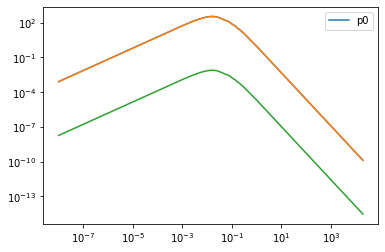

In [60]:
mf.z=10
plt.plot(mf.k, mf._power0*np.power(D(10)/D(0),2), label="p0")
plt.plot(mf.k, mf.power)
#plt.plot(mf.k, mf.nonlinear_power)
plt.plot(mf.k, mf._unnormalised_power)
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [180]:
pc=3.0856775e18
kpc = 1.e3*pc
Mpc=1.e6*pc
r_ph =  7.987e-02/(11)*Mpc

In [30]:
BEHROOZI_MASS = False

def dN_dmdr(m, m_h,r,z):
    #used to calc LW radiation, from eq 1 in https://arxiv.org/pdf/2105.12637.pdf
    start = time.time()
    eta = nonlinear_bias(m, m_h, r,z)
    total1 = time.time()-start
    start = time.time()

    mass = mass_function(m,z)
    total2 = time.time()-start
    print(total2, total1)
    return 4*np.pi*r*r*np.float_power(1+z,3) * mass * (1+eta)

def L_lw(m, z):
    a = 12.4/2.4
    h = 6.626e-27 
    #t = 83*np.float_power((1+z)/11,-3/2) #myr
    t = 18*np.float_power((1+z)/31,-3/2) #myr
    Q_lw = 1e47*np.float_power(1+t/4,-3/2)*np.exp(-t/300)
    f_esc = 1
    m_star = calc_m_star(m,z) #
    return a*h*Q_lw * f_esc * m_star
def f_mod(r,z):
    r_cMpc = r*(1+z)
    a = 0.7/h/np.sqrt(0.27/OMEGA_M)/np.sqrt(21/(1+z))
    if(r_cMpc/a <= 97.39): return 1.7*np.exp(-np.power(r_cMpc/116.29/a,0.68)) - 0.7
    else: return 0


def J_mean(m,z,r):
    r = r/
    return L_lw(m, z)/np.power(4.*np.pi*r_ph,2)*1e21

def calc_m_star(m,z):
    if(BEHROOZI_MASS): return calc_mass_beh_2019([m],[z])[0]
    else: return 0.05*OMEGA_B/OMEGA_M * m
    
    

def r_s(m,z):
    t_sf = 18*np.float_power((1+z)/31,-3/2)
    n = 0.021*np.float_power((1+z)/11, 3)
    m_star = calc_m_star(m,z) #calc_mass_beh_2019([m],[z])[0]
    return 3e-2*np.float_power(m_star/n, 1/5) * np.float_power(t_sf, 2/5)*1e-3 #Mpc

def T_vir(m,z):
    h=0.7
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    u=1.22 #for neutral primordial gas
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1
    print(OMEGA_M_Z)

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    print(delta_c)
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def r_vir(m_h,z):
    #returns mpc
    h=0.7
    
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1
    delta_c = 18*np.pi*np.pi + 82*d -39*d*d

    return 1e-3*0.784/h* np.float_power(m_h*h/1e8, 1.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * (delta_c/(18*np.pi*np.pi)), -1.0/3) * (10/(1+z))




def J_lw(m_h, z, m_max=1e10):
    ####both radii currently in units of kpc h^-1


    lambda_b = 1026
    lambda_lw1 = 1110
    hubble_dist = 4219.5 #Mpc
    wave_dif =  (lambda_lw1-lambda_b)/lambda_b
    r_max_constant = wave_dif*hubble_dist
    r_max = r_max_constant/np.sqrt(OMEGA_M*np.float_power(1+z, 3) + OMEGA_L)

    r_min = max(r_vir(m_h, z) + r_vir(m, z), r_s(m,z))
    
    m_min = 6*1e6 * np.power((1+z)/31, -3.0/2.0)
    print(m_min, m_max,r_min, r_max)
    
    return dblquad(J_lw_int, m_min, m_max, r_min, r_max, args=(m_h,z) )

def J_lw2(m_h, z, m_max=1e10):
    ####both radii currently in units of kpc h^-1


    mpc_to_cm = 3.086e+24
    
    lambda_b = 1026
    lambda_lw1 = 1110
    hubble_dist = 4219.5 #Mpc
    wave_dif =  (lambda_lw1-lambda_b)/lambda_b
    r_max_constant = wave_dif*hubble_dist
    r_max = r_max_constant/np.sqrt(OMEGA_M*np.float_power(1+z, 3) + OMEGA_L)
    
    m_min = 6*1e6 * np.power((1+z)/31, -3.0/2.0)
    total=0
    dr = 0.5
    dm = m_min*5
    m_range = np.arange(m_min, m_max, dm)
    total_m = len(m_range)
    
    #print(m_min/1e7, m_max)
    for m, i in zip(m_range, range(total_m)):
        #print(i, total_m)
        r_min = max(r_vir(m_h, z) + r_vir(m, z), r_s(m,z))
        #print(r_min, r_max)
        
        #return 0
        
        for r in np.arange(r_min, r_max, dr):
            #print(dN_dmdr(m, m_h,r,z)*dr*dm)
#             print(len(np.arange(m_min, m_max, dm)))
#             print(len(np.arange(r_min, r_max, dr)))
#             return 0
            a =J_lw_int(r,m, m_h, z)*dr*dm
#             print(m,r,a)
            total += a
    total = total/np.power(mpc_to_cm, 2)/1e-21
    return total
    
def J_lw_int(r,m, m_h, z):
    #print(m,r)
    start = time.time()
    n = dN_dmdr(m, m_h, r, z)
    total1 = time.time()-start
    start = time.time()
    l = L_lw(m, z)
    total2 = time.time()-start
    print(total1, total2)
    return n* l / (16*np.pi*np.pi * r*r)


SyntaxError: invalid syntax (Temp/ipykernel_19176/889576878.py, line 32)

In [31]:
def read_trees(file):
    f = open(file, "r")
    i=0
    trees=[]
    first = True
    for line in f:
        line = line.strip("\n")
        line=line.split()
        if(i==0):
            N_trees = line[0]
        else:
            ind,snap_num,desc,prog_count,first_prog,next_prog,mass = int(line[0]), int(line[1]), int(line[2]), int(line[3]), int(line[4]), int(line[5]), float(line[6])*1e10
#             try: ind,snap_num,desc,prog_count,first_prog,next_prog,mass,sigma = int(line[0]), int(line[1]), int(line[2]), int(line[3]), int(line[4]), int(line[5]), float(line[6])*1e10, float(line[7]) 
#             except: print(line)
            if(ind == 0):
                if(first):
                    tree=[]
                    first=False
                else:
                    trees.append(np.array(tree))
                    tree=[]
            entry = np.array([ind,snap_num,desc,prog_count,first_prog,next_prog,mass])
            tree.append(entry)
        i+=1
    trees.append(np.array(tree))
    return np.array(trees)

def clean_trees(trees,z,all_=True):
    all_trees = []
    for tree_set in trees:
        
        if(all_):
            num_splits = np.size(np.where(tree_set.T[3] == 0.))
            end_of_trees = np.where(tree_set.T[3] == 0.)[0]
            for end in end_of_trees:
                tree=[]
                index = end
                while(index>-1):
                    #print(index)
                    ind,snap_num,desc,prog_count,first_prog,next_prog,mass = tree_set[index]
                    tree.append(np.array([z[int(snap_num)], mass]))
                    index = int(desc)

                all_trees.append(np.array(tree))
                #return
                
        else:
            index = 0
            tree=[]
            while(index>-1):
                ind,snap_num,desc,prog_count,first_prog,next_prog,mass = tree_set[index]
                tree.append(np.array([z[int(snap_num)], mass]))
                index = int(first_prog)
            all_trees.append(np.array(tree)[::-1])

            
    return all_trees


In [54]:
all_files = glob.glob("j_files/*.txt")
z_list, m_list, j_list = [],[],[]
for file in all_files:
    m_list.append(np.power(10,float((file.split("_")[-1]).split("M")[0])))
    z_list.append(float((file.split("_")[2]).replace("m", "")))
    j_list.append(open(file).readlines()[-1].split()[6])
f = open("J_lw.txt", "w")
f.write("z    mass    j\n")
for x in range(len(z_list)): f.write(str(z_list[x]) + "   " + str(m_list[x]) + "   " + str(j_list[x])+ "\n")
f.close()

In [56]:
j_lw = pd.read_csv("J_lw.txt", delim_whitespace=True)

In [57]:
j_lw

,z,mass,j
0,10.067089,1.000000e+10,65.87
1,10.067089,3.162278e+10,78.21
2,10.067089,1.000000e+11,105.80
3,10.067089,3.162278e+11,191.00
4,10.067089,1.000000e+12,599.40
...,...,...,...
910,9.898945,3.162278e+07,52.09
911,9.898945,1.000000e+08,52.82
912,9.898945,3.162278e+08,53.88
913,9.898945,1.000000e+09,55.97


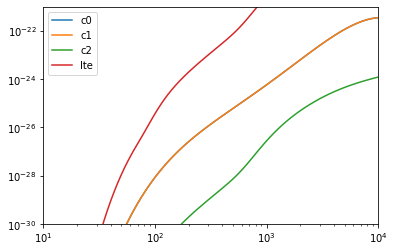

In [187]:
t_list = np.logspace(1,4,100)
cooling0 = cooling_GP(t_list)
cooling1 = total_cooling(t_list, 0.00001)
cooling2 = total_cooling(t_list, 1e6)
coolinglte = cooling_LTE(t_list,1)

plt.plot(t_list, cooling0, label="c0")
plt.plot(t_list, cooling1, label="c1")
plt.plot(t_list, cooling2, label="c2")
plt.plot(t_list, coolinglte, label="lte")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-30,1e-21)
plt.xlim(10,1e4)
plt.legend()

In [93]:
def get_v2(z,m):
    return delta_c/D(z)/np.sqrt(get_sigma(m_to_r(m)))


def dlogv_dlogm(z,m,v,dm=0.01):
    v_big = get_v2(z,m+dm)
    v_low = v
    #return (v_big-v_low)/(dm)
    return (np.log(v_big/v_low))/(np.log((m+dm)/m))


def v_fv(v):
    A = 0.3222
    q =  0.3
    v=v*np.sqrt(0.707)
    return 2*A*(1+1/np.power(v,2*q))*np.sqrt(v*v/(2*np.pi))*np.exp(-v*v/2)
    

def mass_function(m,z):
    times=[]
    start = time.time()

    v = get_v2(z,m)
    
    times.append(time.time()-start)
    start = time.time()

    v_fv1 = v_fv(v)
    times.append(time.time()-start)
    start = time.time()
    
    p    = rho_crit
    times.append(time.time()-start)
    start = time.time()
    
    dlv_dlm = dlogv_dlogm(z,m,v)
    times.append(time.time()-start)
    
    #print(times)
    #print(v_fv1,p,dlv_dlm, m/1e10)
    
    return v_fv1*p*dlv_dlm/(m*m)

In [51]:
def sigma(R):
    return quad(sigma_int, 0, np.inf, args=(R), maxp1=200, epsabs=1e-12)[0]

def sigma_int(k,R):
    return np.power(k,2)/(2*np.pi**2)*ps(k)*W(k*R)*W(k*R)

def linear_bias(d,m1,m2):  
    r1 = np.power((3.*m1)/(4.*np.pi*rho_aver0), 1./3)
    r2 = np.power((3.*m2)/(4.*np.pi*rho_aver0), 1./3)
    r_max = max(r1,r2)
    return 1/(2*np.pi**2)/sigma(8) * quad(ps_int, 0, np.inf, args=(d,r_max),epsabs=1e-12, maxp1=400)[0]


def linear_bias2(d,m1,m2):  
    r1 = np.power((3.*m1)/(4.*np.pi*rho_aver0), 1./3)
    r2 = np.power((3.*m2)/(4.*np.pi*rho_aver0), 1./3)
    r_max = max(r1,r2)
    return 1/(2*np.pi**2)/sigma(8) * quad(ps_int2, 0, np.inf, args=(d,r_max),epsabs=1e-12, maxp1=400)[0]

H0 = 100
G = 4.2994e-9
rho_aver0 = 0.27*3.0*H0*H0 / (8.0 * np.pi * G)

def m_to_r(m):
    r = np.power((3.*m)/(4.*np.pi*rho_aver0), 1./3)
    return r

def r_to_m(r):
    m = np.power(r,3)*(4.*np.pi*rho_aver0)/3
    return m


def ps_int(k,d,r_max):
    return k*k*np.sin(k*d)/(k*d)*ps(k)*W(k*r_max)*W(k*r_max)

def ps_int2(k,d,r_max):
    return k*k*np.sin(k*d)/(k*d)*ps2(k)*W(k*r_max)*W(k*r_max)


def W(x):
    return 3*(np.sin(x)/x - np.cos(x))/(np.power(x,2))


def ps(k):
    Gamma_cosmo=0.21
    nspec=1
    k0 = 100
    q = k/Gamma_cosmo
    t1 = np.log(1.0+2.34*q)/(2.34*q)
    t2 = 1.0 + (3.89*q) + np.power(16.1*q, 2) + np.power(5.46*q, 3) + np.power(6.71*q, 4)
    tk = t1*np.power(t2, -0.25)
    ps = tk*tk*np.float_power(k/k0, nspec)
    return ps

def ps2(k):
    #Eisenstein and hu power spectrum
    E = 2.7182818
    k0 = 100
    nspec = 0.95
    Omega_M0 = 0.27 
    xhubble = 0.70 
    Omega_Baryon0_h2 = 0.022981 
    Omega_Baryon0 = Omega_Baryon0_h2/xhubble/xhubble 
    f_bar = Omega_Baryon0/Omega_M0 
    f = Omega_M0 * xhubble*xhubble 

    bb1 = 0.313 * np.power(f, -0.419) * (1.0 + 0.607*np.power(f, 0.674)) 
    bb2 = 0.238 * np.power(f, 0.223) 

    bnode = 8.41* np.power(f, 0.435) 

    keq = 7.46e-2 * f 
    ksilk = 1.6 * np.power(Omega_Baryon0_h2, 0.52) * np.power(f, 0.73) * (1.0 + np.power(10.4*f,-0.95)) 

    zeq = 2.5e+4 * f 
    zd = 1291.0 * np.power(f, 0.251)/(1.0 + 0.659*np.power(f, 0.828)) * (1.0 + bb1 * np.power(Omega_Baryon0_h2, bb2)) 
    y = ((1.0+zeq)/(1.0+zd)) 
    Fy = np.log((np.sqrt(1.0+y) + 1.0) / (np.sqrt(1.0+y) - 1.0)) 
    Gy = y * (-6.0 * np.sqrt(1.0+y) + (2.0+3.0*y) * Fy) 

    Req = 31.5 * Omega_Baryon0_h2 * (1000.0/zeq) 
    Rd  = 31.5 * Omega_Baryon0_h2 * (1000.0/zd) 

    sEH = (2.0/(3.0*keq)) * np.sqrt(6.0/Req) * np.log((np.sqrt(1.0+Rd) + np.sqrt(Rd+Req))/(1.0+np.sqrt(Req))) 

    a1 = np.power(46.9*f, 0.670) * (1.0 + np.power(32.1*f, -0.532)) 
    a2 = np.power(12.0*f, 0.424) * (1.0 + np.power(45.0*f, -0.582)) 
    b1 = 0.944 / (1.0+np.power(458.0*f, -0.708)) 
    b2 = np.power(0.395*f, -0.0266) 

    alpha_c = np.power(a1, -f_bar) * np.power(a2, -(f_bar*f_bar*f_bar)) 
    beta_c = 1.0 + b1*(np.power((Omega_M0-Omega_Baryon0)/Omega_M0, b2) - 1.0) 
    beta_c = 1.0/beta_c 

    alpha_b = 2.07 * keq * sEH * np.power(1.0+Rd, -0.75) * Gy 
    beta_b = 0.5 + f_bar + (3.0-2.0*f_bar) * np.sqrt(np.power(17.2*f, 2) + 1.0) 
    
    q = k/(13.41*keq) 

    silk = np.power(k/ksilk,1.4) 
    silk = np.exp(-silk) 
    stilde = sEH/np.power(1.+np.power(bnode/(k*sEH), 3),0.3333) 

    fff = 1.0/(1.0 + np.power(k*sEH/5.4, 4)) 
    C1 = 14.2 + 386.0/(1.0+69.0*np.power(q,1.08)) 
    C2 = 14.2/alpha_c + 386.0/(1.0 + 69.9*np.power(q,1.08)) 

    t11 = np.log(E + 1.8*beta_c*q) 
    t12 = np.log(E + 1.8*q) 

    t1 = t11/(t11 + C1*q*q) 
    t2 = t11/(t11 + C2*q*q) 
    t3 = t12/(t12 + C1*q*q) 

    tb1 = t3/( 1.0 + np.power(k*sEH/5.2, 2)) 
    tb2 = (alpha_b/(1.0 + np.power(beta_b/(k*sEH), 3))) *silk 

    T_c = fff*t1 + (1.-fff)*t2 
    T_b = (tb1 + tb2) * np.sin(k*stilde)/(k*stilde) 

    tk = (Omega_Baryon0/Omega_M0)*T_b + (Omega_M0-Omega_Baryon0)/Omega_M0 * T_c     
    ps = tk*tk*np.power(k/k0, nspec)
    return ps

# k_list = np.power(10, np.linspace(-3,0,30))
# tk_list = ps2(k_list)
# plt.plot(k_list, tk_list)
# plt.yscale("log")
# plt.xscale("log")

In [ ]:
#old PS, eisenstein + hu 
def ps2(k):
    #Eisenstein and hu power spectrum
    E = 2.7182818
    k0 = 100
    nspec = 1
    Omega_M0 = OMEGA_M
    xhubble = 0.71
    Omega_Baryon0_h2 = 0.022981 
    Omega_Baryon0 = Omega_Baryon0_h2/xhubble/xhubble 
    f_bar = Omega_Baryon0/Omega_M0 
    f = Omega_M0 * xhubble*xhubble 

    bb1 = 0.313 * np.power(f, -0.419) * (1.0 + 0.607*np.power(f, 0.674)) 
    bb2 = 0.238 * np.power(f, 0.223) 

    bnode = 8.41* np.power(f, 0.435) 

    keq = 7.46e-2 * f 
    ksilk = 1.6 * np.power(Omega_Baryon0_h2, 0.52) * np.power(f, 0.73) * (1.0 + np.power(10.4*f,-0.95)) 

    zeq = 2.5e+4 * f 
    zd = 1291.0 * np.power(f, 0.251)/(1.0 + 0.659*np.power(f, 0.828)) * (1.0 + bb1 * np.power(Omega_Baryon0_h2, bb2)) 
    y = ((1.0+zeq)/(1.0+zd)) 
    Fy = np.log((np.sqrt(1.0+y) + 1.0) / (np.sqrt(1.0+y) - 1.0)) 
    Gy = y * (-6.0 * np.sqrt(1.0+y) + (2.0+3.0*y) * Fy) 

    Req = 31.5 * Omega_Baryon0_h2 * (1000.0/zeq) 
    Rd  = 31.5 * Omega_Baryon0_h2 * (1000.0/zd) 

    sEH = (2.0/(3.0*keq)) * np.sqrt(6.0/Req) * np.log((np.sqrt(1.0+Rd) + np.sqrt(Rd+Req))/(1.0+np.sqrt(Req))) 

    a1 = np.power(46.9*f, 0.670) * (1.0 + np.power(32.1*f, -0.532)) 
    a2 = np.power(12.0*f, 0.424) * (1.0 + np.power(45.0*f, -0.582)) 
    b1 = 0.944 / (1.0+np.power(458.0*f, -0.708)) 
    b2 = np.power(0.395*f, -0.0266) 

    alpha_c = np.power(a1, -f_bar) * np.power(a2, -(f_bar*f_bar*f_bar)) 
    beta_c = 1.0 + b1*(np.power((Omega_M0-Omega_Baryon0)/Omega_M0, b2) - 1.0) 
    beta_c = 1.0/beta_c 

    alpha_b = 2.07 * keq * sEH * np.power(1.0+Rd, -0.75) * Gy 
    beta_b = 0.5 + f_bar + (3.0-2.0*f_bar) * np.sqrt(np.power(17.2*f, 2) + 1.0) 
    
    q = k/(13.41*keq) 

    silk = np.power(k/ksilk,1.4) 
    silk = np.exp(-silk) 
    stilde = sEH/np.power(1.+np.power(bnode/(k*sEH), 3),0.3333) 

    fff = 1.0/(1.0 + np.power(k*sEH/5.4, 4)) 
    C1 = 14.2 + 386.0/(1.0+69.0*np.power(q,1.08)) 
    C2 = 14.2/alpha_c + 386.0/(1.0 + 69.9*np.power(q,1.08)) 

    t11 = np.log(E + 1.8*beta_c*q) 
    t12 = np.log(E + 1.8*q) 

    t1 = t11/(t11 + C1*q*q) 
    t2 = t11/(t11 + C2*q*q) 
    t3 = t12/(t12 + C1*q*q) 

    tb1 = t3/( 1.0 + np.power(k*sEH/5.2, 2)) 
    tb2 = (alpha_b/(1.0 + np.power(beta_b/(k*sEH), 3))) *silk 

    T_c = fff*t1 + (1.-fff)*t2 
    T_b = (tb1 + tb2) * np.sin(k*stilde)/(k*stilde) 

    tk = (Omega_Baryon0/Omega_M0)*T_b + (Omega_M0-Omega_Baryon0)/Omega_M0 * T_c     
    ps = tk*tk*np.power(k/k0, nspec)
    return ps

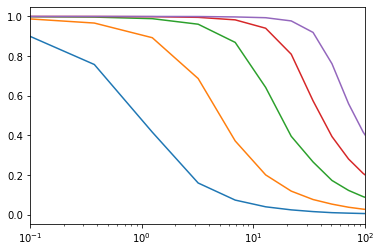

In [318]:
plt.figure()
plt.xscale("log")
plt.xlim(0.1,100)
for d in [10,3.3,1,0.33,0.1]:
    e_list, sigma_list = [],[]
    for masspow in range(2,18,1):
        mass = np.float_power(10,masspow)
        e_list.append(linear_bias(d,mass,mass))
        #sigma_list.append(get_sigma(1e-10*mass))
        sigma_list.append(sigma(m_to_r(mass)))
        r_list.append(m_to_r(mass))

    sigma_list = np.array(sigma_list)
    e_list = np.array(e_list)


    plt.plot(sigma_list/sigma(8), e_list/sigma_list)

In [88]:
z = get_redshift("Snapshot_alist_mod")
trees = read_trees("1e13")
trees = clean_trees(trees,z,all_=False)

In [44]:
z = get_redshift("Snapshot_alist_mod")
trees11 = read_trees("1e11")
trees11 = clean_trees(trees11,z,all_=False)

In [3]:

all_ms =[]
for x in range(len(trees)):
    z,m = trees[x].T
    z13 = np.log10(z+1)
    m = np.log10(m/1e13)
    all_ms.append(m)
all_ms = np.array(all_ms)
m_av13 = []
for x in range(len(z13)): m_av13.append(np.mean(all_ms.T[x]))

#print(len(all_ms.T))
  
all_ms, all_zs =[],[]
for x in range(len(trees11)):
    z,m = trees11[x].T
    z11 = np.log10(z+1)
    m = np.log10(m/1e11)
    all_ms.append(np.array(m)), all_zs.append(z)
all_ms = np.array(all_ms)
m_av11 = []

for x in range(len(z11)):
    total, N = 0,0
    for y in range(len(all_ms)):
        if((len(all_ms[y]) -1) >= x):
            total +=all_ms[y][x]
            N+=1
    #print(len(all_ms[y]), x)
    m_av11.append(total/N)

    
plt.figure()
plt.xlim(0,1.1)
plt.ylim(-3.7,0)
plt.plot(z13,m_av13, label="M0 = 1e13")
plt.plot(z11,m_av11, label="M0 = 1e11")
plt.xlabel("log(1+z)")
plt.ylabel(r"log$(M_{\rm halo}/M_0)$")
plt.legend()

NameError: name 'trees' is not defined

Text(0, 0.5, '$M_{\\rm halo} \\ [M_{\\odot}]$')

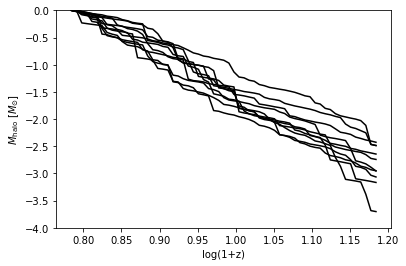

In [62]:
plt.figure()
#plt.xlim(0,1.2)
plt.ylim(-4.0,0)
#plt.yscale("log")
for x in range(len(trees_full_main)):
    z,m = trees_full_main[x].T[0],trees_full_main[x].T[2]
    z = np.log10(z+1)
    m = np.log10(m/1e12)
    plt.plot(z,m, c="black")
plt.xlabel("log(1+z)")
plt.ylabel(r"$M_{\rm halo} \ [M_{\odot}]$")
#plt.savefig("mc_merger_example.pdf")

In [81]:
z = get_redshift("Snapshot_alist_mod")
trees = read_trees("4e11_6_to_18")
trees = clean_trees(trees,z,all_=False)

Text(0, 0.5, '$M_{\\rm halo} \\ [M_{\\odot}]$')

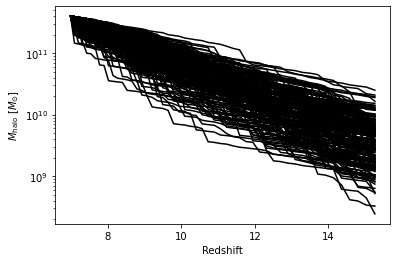

In [86]:
plt.figure()
#plt.xlim(0,1.2)
#plt.ylim(-3.5,0)
plt.yscale("log")
for x in range(len(trees)):
    z,m = trees[x].T
    z = z+1
    m = m
    plt.plot(z,m, c="black")
#plt.xlabel("log(1+z)")
plt.xlabel("Redshift")
plt.ylabel(r"$M_{\rm halo} \ [M_{\odot}]$")
#plt.savefig("mc_merger_example.pdf")